### Importing the theoretical $D_{l}$ obtained with CAMB (Lewis & Challinor 2011; Lewis et al. 2000)

These are the steps for generating a simple CMB map realization with white noise  following ( Sullivan et al. (2024)).\
1.Generate from CAMB or CLASS the desired power spectrum $C_\ell$. (or another option we can download  a precomputed one; e.g.\
for Planck mission)\
2.Convolve the power spectrum with the beam $B_\ell$ and pixel window function $P_\ell$\
3.Add the desired noise spectrum $\epsilon_\ell$ \
4.Generate the map (from the randomised $\a_{l m}$)\.
5.Mask the map (ensure that the mask is apodised for centain procedures).
                                                                                  
                                                                            

#### Step 1: Generating the input $C_\ell s$ from CAMB

In [203]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from input_camb import *
import healpy as hp

[matplotlib.pyplot] Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [205]:
# This Dl is used as input for synthetic map (with len(el)=2551)
Dl

array([   0.        ,    0.        , 1028.01454306, ...,   66.35034063,
         66.2225099 ,   66.09623955])

In [206]:
ls=np.arange((Dl.shape[0]))

In [207]:
ls

array([   0,    1,    2, ..., 2548, 2549, 2550])

##### Step 2: convolving the power spectrum with the beam $B_\ell$ and pixel window function $P_\ell$

Following Planck collaboration (2018), we choose the $FWHM = 5 min$ as we in a Planck SMICA map.\
$C_l^{obs} = B_l^{2} C_l$

In [210]:
fwhm=np.radians(5/60)

lmax=2000
B_l=hp.gauss_beam(fwhm,lmax, pol=False)
D_l=Dl[:2001]/(B_l**2)

In [ ]:
#### Step

In [114]:
lmax = 2000
nside=2048
mapa_cl = hp.sphtfunc.synfast(Dl, nside=nside, lmax =lmax, fwhm=np.radians(1/60), new= True)

[healpy] Sigma is 0.424661 arcmin (0.000124 rad) 
[healpy] -> fwhm is 1.000000 arcmin


[matplotlib.colorbar] locator: <healpy.projaxes.BoundaryLocator object at 0x7f01983bd390>


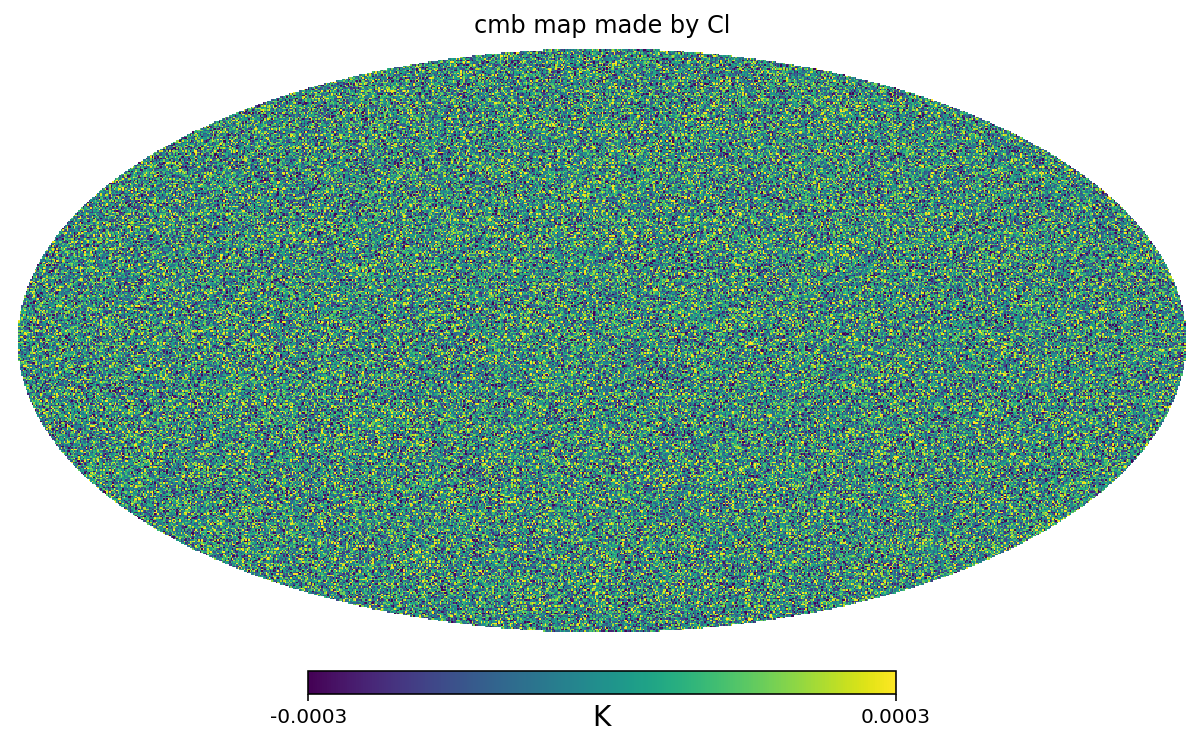

In [115]:
hp.mollview(mapa_cl*(1e-8), title = 'cmb map made by Cl', unit = 'K', min=-3e-4, max=3e-4)

In [116]:
#Saving the map
cmb_map=np.save('mapa_cl_1', mapa_cl)

In [146]:
# ells
Cls=hp.anafast(mapa_cl, lmax=2000)
el=np.arange(len(Cls))
el

array([   0,    1,    2, ..., 1998, 1999, 2000])

I am going to compute the noise for these synthetic map\
Following Planck collaboration (2018):

In [119]:
noise_std_pixel= 13.7 #muK²
beam_FWHM =  1/60 #sexagesimal minute
pixel_area_rad = np.pi / (3 * nside ** 2)
weight_per_solid_angle = (noise_std_pixel ** 2 * pixel_area_rad) ** -1
beam_sigma_rad = beam_FWHM / np.sqrt(8 * np.log(2)) * np.pi / 180.
ells = np.arange(lmax + 1)
Nl = np.exp((ells * beam_sigma_rad) ** 2) / weight_per_solid_angle

In [133]:
# Total uncertainties due the cosmic variance and the noise of the map
# We remove the dipole and l=0
std_cls=np.sqrt(2 / (2*el[2:] + 1))*Cls[2:]
std_cls.shape
tot_err=std_cls+Nl[2:]
Cls[2:].shape

(1999,)

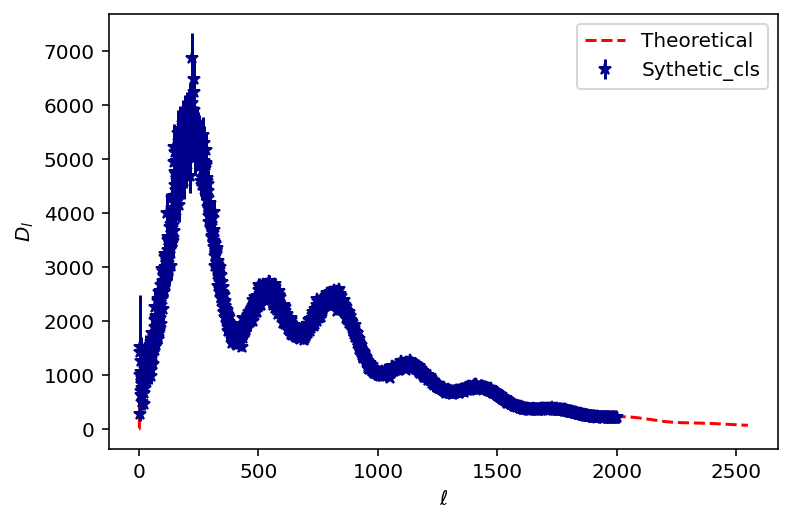

In [134]:
plt.plot(ls,Dl,'--',  color= 'r', label='Theoretical')
plt.errorbar(el[2:],Cls[2:],yerr=tot_err,fmt='*', color = 'darkblue', label='Sythetic_cls')
plt.xlabel('$\ell$')
plt.ylabel(r'$D_l$')
plt.legend()

Converting the data in a numpy array to store in a txt file

Experimental errors

In [57]:
from IPython.display import display, Math
display(Math(r'\sigma(C_{\ell})= \sqrt{\frac{2}{(2l+1)f_{sky}}} \cdot C_{\ell}'))

<IPython.core.display.Math object>

In this subsection, I am going to compute the errors of pseudo \(C_\ell\). To compute the errors for thepower spectrum, you can estimate them using a simple approximation. One of the most straightforward methods is to assume that the errors are dominated by cosmic variance and noise, which gives:

$$\sigma(C_{\ell})= \sqrt{\frac{2}{(2l+1)f_{sky}} \cdot C_{\ell}}$$

Where $C_{\ell}$ are my pseudo power spectrum,
$f_{sky}=1$ is fraction of our sky for analysis.

We are going to save the file as txt file for our Cobaya likelihood

In [141]:
data_cls=np.column_stack((el[2:],Cls[2:],tot_err))

In [190]:
min(el[2:])

2

In [179]:
# Define the path to the text file
text_file_path = 'my_cl_data.txt'

In [180]:
# Save the numpy array as txt file with  space as delimiter
np.savetxt(text_file_path, data_cls, delimiter=' ')

## MCMC with Cobaya (Lewis  & Torrado 2021)

In [181]:
from cobaya.likelihood import Likelihood
import os

I establish the Likelihood 

In [198]:
class MyCustomLikelihood(Likelihood):
    def initialize(self):
        """Prepare any computation, importing necessary code, files, etc."""
        # Load your data file, for example, experimental Cls
        self.ell, self.data_Cl_TT, self.error = np.loadtxt('my_cl_data.txt', unpack=True)
    
    def get_requirements(self):
        """Return dictionary specifying quantities calculated by a theory code."""
        # Request C_l^{TT} (temperature) up to the maximum ell in your data
        return {'Cl': {'tt': 2000}}
    
    def logp(self, **params_values):
        """Compute the log-likelihood given a set of parameter values."""
        # Get the theoretical Cls from the theory code (e.g., CAMB or CLASS)
        cls = self.provider.get_unlensed_cl(ell_factor=True, units='muK2')
        
        # Calculate chi-squared: sum of squared differences between data and theory Cls
        chi2 = np.sum(((self.data_Cl_TT - cls['tt'][2:]) / self.error) ** 2)
        
        # Return the log-likelihood (-0.5 * chi2)
        return -0.5 * chi2

Sampling the parameters

The base set of cosmological parameters we sample over are $\Omega_b h^{2}$ and $\Omega_c h^{2}$, the physical barion density and the CDM density
to critical density of universe, $h=H_0/(100 Km s^{-1} Mpc^{-1})$.

In [199]:
from cobaya import run

In [202]:
# Example of how to configure Cobaya with this likelihood
info_params = {
    "debug": True,
    "likelihood": {
        "MyCustomLikelihood": MyCustomLikelihood
    },
    "theory": {
        "camb": {
            "extra_args": {
                "lmax": 2000
            }
        }
    },
    "params": {
        "ombh2": {"prior": {"min": 0.005, "max": 0.1}, "ref": {"dist": "norm", "loc": 0.022, "scale": 0.001}},
        "omch2": {"prior": {"min": 0.05, "max": 0.5}, "ref": {"dist": "norm", "loc": 0.12, "scale": 0.01}}
    },
    "sampler": {
        "mcmc": {
            "max_tries": 1000
        }
    },
    "debug": True
}

# Running Cobaya
from cobaya import run
updated_info, sampler = run(info_params)

[outputdummy] No output requested. Doing nothing.
[run] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: false
    extra_args:
      lmax: 2000
    ignore_obsolete: false
    use_renames: false
    external_primordial_pk: false
    renames:
      omegabh2: ombh2
      omegach2: omch2
      omegal: omega_de
      omegak: omk
      yhe: YHe
      yheused: YHe
      YpBBN: Y_p
likelihood:
  MyCustomLikelihood:
    type: []
    speed: -1
    stop_at_error: false
    version: null
    external: !!python/name:__main__.MyCustomLikelihood ''
params:
  ombh2:
    prior:
      min: 0.005
      max: 0.1
    ref:
      dist: norm
      loc: 0.022
      scale: 0.001
    renames:
    - omegabh2
  omch2:
    prior:
      min: 0.05
      max: 0.5
    ref:
      dist: norm
      loc: 0.12
      scale: 0.01
    renames:
    - omegach2
sampler:
  mcmc:
    burn_in: 0
    max_tries: 1000
    covmat: null
    covmat_params

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02116520632273112, 'omch2': 0.11596595840558033}
[camb.transfers] Got parameters {'ombh2': 0.02116520632273112, 'omch2': 0.11596595840558033}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02116520632273112, 'omch2': 0.11596595840558033} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02200623, 0.09781849])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022006229488281053, 'omch2': 0.09781849498767006}
[prior] Evaluating prior at array([0.02200623, 0.09781849])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022006229488281053, 'omch2': 0.09781849498767006}
[camb.transfers] Got parameters {'ombh2': 0.022006229488281053, 'omch2': 0.09781849498767006}
[camb.transfers] Computing new state
[

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02383232002437836, 'omch2': 0.13153029246418665} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02298686, 0.11644186])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022986855837068658, 'omch2': 0.11644186393660394}
[prior] Evaluating prior at array([0.02298686, 0.11644186])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022986855837068658, 'omch2': 0.11644186393660394}
[camb.transfers] Got parameters {'ombh2': 0.022986855837068658, 'omch2': 0.11644186393660394}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022986855837068658, 'omch2': 0.11644186393660394} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02084267, 0.10687364])
[prior] Got

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022275055031620538, 'omch2': 0.11386488760315003}
[prior] Evaluating prior at array([0.02227506, 0.11386489])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022275055031620538, 'omch2': 0.11386488760315003}
[camb.transfers] Got parameters {'ombh2': 0.022275055031620538, 'omch2': 0.11386488760315003}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022275055031620538, 'omch2': 0.11386488760315003} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209397, 0.11643682])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022093974167270117, 'omch2': 0.11643681987418478}
[prior] Evaluating prior at array([0.02209397, 0.11643682])
[prior] Got logpriors (internal) = 3.15238608359936

[model] Got input parameters: {'ombh2': 0.022967924724846267, 'omch2': 0.11501958674351365}
[camb.transfers] Got parameters {'ombh2': 0.022967924724846267, 'omch2': 0.11501958674351365}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022967924724846267, 'omch2': 0.11501958674351365} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.01995228, 0.12868259])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.019952279340274305, 'omch2': 0.1286825947821703}
[prior] Evaluating prior at array([0.01995228, 0.12868259])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.019952279340274305, 'omch2': 0.1286825947821703}
[camb.transfers] Got parameters {'ombh2': 0.019952279340274305, 'omch2': 0.1286825947821703}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.019952279340274

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02353544, 0.11535384])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02353543662587676, 'omch2': 0.11535384134302318}
[prior] Evaluating prior at array([0.02353544, 0.11535384])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02353543662587676, 'omch2': 0.11535384134302318}
[camb.transfers] Got parameters {'ombh2': 0.02353543662587676, 'omch2': 0.11535384134302318}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02353543662587676, 'omch2': 0.11535384134302318} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0223604, 0.1279916])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022360403202141187, 'omch2': 0.1279916046547295}

[prior] Evaluating prior at array([0.02220951, 0.11495561])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022209507540013395, 'omch2': 0.11495560593007811}
[camb.transfers] Got parameters {'ombh2': 0.022209507540013395, 'omch2': 0.11495560593007811}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022209507540013395, 'omch2': 0.11495560593007811} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02305135, 0.12229005])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02305135215817403, 'omch2': 0.12229004827391969}
[prior] Evaluating prior at array([0.02305135, 0.12229005])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02305135215817403, 'omch2': 0.12229004827391969}
[camb.transfers] Got parameters {'ombh2': 0.02305135215817403, 'omch2':

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.020797241950224806, 'omch2': 0.1147306030724792} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02162756, 0.11323283])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021627558980101762, 'omch2': 0.11323283078484554}
[prior] Evaluating prior at array([0.02162756, 0.11323283])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021627558980101762, 'omch2': 0.11323283078484554}
[camb.transfers] Got parameters {'ombh2': 0.021627558980101762, 'omch2': 0.11323283078484554}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021627558980101762, 'omch2': 0.11323283078484554} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02033092, 0.12424186])
[prior] Got

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.024184123885475063, 'omch2': 0.10374249147481211}
[prior] Evaluating prior at array([0.02418412, 0.10374249])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.024184123885475063, 'omch2': 0.10374249147481211}
[camb.transfers] Got parameters {'ombh2': 0.024184123885475063, 'omch2': 0.10374249147481211}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.024184123885475063, 'omch2': 0.10374249147481211} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02253617, 0.13629772])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022536173857075733, 'omch2': 0.13629772266791707}
[prior] Evaluating prior at array([0.02253617, 0.13629772])
[prior] Got logpriors (internal) = 3.15238608359936

[model] Got input parameters: {'ombh2': 0.02277733212074573, 'omch2': 0.12424281353381994}
[camb.transfers] Got parameters {'ombh2': 0.02277733212074573, 'omch2': 0.12424281353381994}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02277733212074573, 'omch2': 0.12424281353381994} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02093691, 0.11317557])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02093691339360448, 'omch2': 0.11317556522942696}
[prior] Evaluating prior at array([0.02093691, 0.11317557])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02093691339360448, 'omch2': 0.11317556522942696}
[camb.transfers] Got parameters {'ombh2': 0.02093691339360448, 'omch2': 0.11317556522942696}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02093691339360448,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0208877 , 0.12263615])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02088769658333007, 'omch2': 0.12263614662801703}
[prior] Evaluating prior at array([0.0208877 , 0.12263615])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02088769658333007, 'omch2': 0.12263614662801703}
[camb.transfers] Got parameters {'ombh2': 0.02088769658333007, 'omch2': 0.12263614662801703}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02088769658333007, 'omch2': 0.12263614662801703} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02131327, 0.12342575])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02131326900466932, 'omch2': 0.1234257513100067

[prior] Evaluating prior at array([0.02094595, 0.13168411])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.020945953442784163, 'omch2': 0.1316841107639516}
[camb.transfers] Got parameters {'ombh2': 0.020945953442784163, 'omch2': 0.1316841107639516}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.020945953442784163, 'omch2': 0.1316841107639516} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0208803 , 0.13119686])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.020880295242509277, 'omch2': 0.13119686347597354}
[prior] Evaluating prior at array([0.0208803 , 0.13119686])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.020880295242509277, 'omch2': 0.13119686347597354}
[camb.transfers] Got parameters {'ombh2': 0.020880295242509277, 'omch2':

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.023134175374346772, 'omch2': 0.1286411963240573} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0228516 , 0.10384027])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022851595932457898, 'omch2': 0.10384027239843857}
[prior] Evaluating prior at array([0.0228516 , 0.10384027])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022851595932457898, 'omch2': 0.10384027239843857}
[camb.transfers] Got parameters {'ombh2': 0.022851595932457898, 'omch2': 0.10384027239843857}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022851595932457898, 'omch2': 0.10384027239843857} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.01996391, 0.11892477])
[prior] Got

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021966926001086583, 'omch2': 0.11555992781746828}
[prior] Evaluating prior at array([0.02196693, 0.11555993])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021966926001086583, 'omch2': 0.11555992781746828}
[camb.transfers] Got parameters {'ombh2': 0.021966926001086583, 'omch2': 0.11555992781746828}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021966926001086583, 'omch2': 0.11555992781746828} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02228806, 0.11631855])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022288059092160327, 'omch2': 0.11631855014490511}
[prior] Evaluating prior at array([0.02228806, 0.11631855])
[prior] Got logpriors (internal) = 3.15238608359936

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.023455457692686504, 'omch2': 0.11190476062483733}
[camb.transfers] Got parameters {'ombh2': 0.023455457692686504, 'omch2': 0.11190476062483733}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.023455457692686504, 'omch2': 0.11190476062483733} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02154993, 0.13119751])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021549934575545295, 'omch2': 0.13119751401032484}
[prior] Evaluating prior at array([0.02154993, 0.13119751])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021549934575545295, 'omch2': 0.13119751401032484}
[camb.transfers] Got parameters {'ombh2': 0.021549934575545295, 'omch2': 0.13119751401032484}
[camb.transfers] Computing new stat

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022180435636302166, 'omch2': 0.12555088751988916} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02188202, 0.12251388])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021882021378108654, 'omch2': 0.12251387737532263}
[prior] Evaluating prior at array([0.02188202, 0.12251388])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021882021378108654, 'omch2': 0.12251387737532263}
[camb.transfers] Got parameters {'ombh2': 0.021882021378108654, 'omch2': 0.12251387737532263}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021882021378108654, 'omch2': 0.12251387737532263} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02130206, 0.10079458])
[prior] Go

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02180911693185168, 'omch2': 0.1282955239496695}
[prior] Evaluating prior at array([0.02180912, 0.12829552])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02180911693185168, 'omch2': 0.1282955239496695}
[camb.transfers] Got parameters {'ombh2': 0.02180911693185168, 'omch2': 0.1282955239496695}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02180911693185168, 'omch2': 0.1282955239496695} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0226855 , 0.11480756])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022685497339708594, 'omch2': 0.11480755534392584}
[prior] Evaluating prior at array([0.0226855 , 0.11480756])
[prior] Got logpriors (internal) = 3.152386083599368
[model

[model] Got input parameters: {'ombh2': 0.02309763227905806, 'omch2': 0.12611424457756257}
[camb.transfers] Got parameters {'ombh2': 0.02309763227905806, 'omch2': 0.12611424457756257}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02309763227905806, 'omch2': 0.12611424457756257} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02255871, 0.11114375])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022558708032598688, 'omch2': 0.11114374838879318}
[prior] Evaluating prior at array([0.02255871, 0.11114375])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022558708032598688, 'omch2': 0.11114374838879318}
[camb.transfers] Got parameters {'ombh2': 0.022558708032598688, 'omch2': 0.11114374838879318}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022558708032598

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0210351 , 0.12780027])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021035097707883914, 'omch2': 0.12780027031965183}
[prior] Evaluating prior at array([0.0210351 , 0.12780027])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021035097707883914, 'omch2': 0.12780027031965183}
[camb.transfers] Got parameters {'ombh2': 0.021035097707883914, 'omch2': 0.12780027031965183}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021035097707883914, 'omch2': 0.12780027031965183} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02330709, 0.12250911])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.023307090836196878, 'omch2': 0.12250910808

[prior] Evaluating prior at array([0.02248844, 0.1227189 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022488444498911905, 'omch2': 0.12271890380162456}
[camb.transfers] Got parameters {'ombh2': 0.022488444498911905, 'omch2': 0.12271890380162456}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022488444498911905, 'omch2': 0.12271890380162456} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02228944, 0.11866589])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022289435013916406, 'omch2': 0.11866588720576161}
[prior] Evaluating prior at array([0.02228944, 0.11866589])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022289435013916406, 'omch2': 0.11866588720576161}
[camb.transfers] Got parameters {'ombh2': 0.022289435013916406, 'omch

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.020262524415683113, 'omch2': 0.13975186293337305} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0214496 , 0.12177542])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021449602344920958, 'omch2': 0.1217754200621153}
[prior] Evaluating prior at array([0.0214496 , 0.12177542])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021449602344920958, 'omch2': 0.1217754200621153}
[camb.transfers] Got parameters {'ombh2': 0.021449602344920958, 'omch2': 0.1217754200621153}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021449602344920958, 'omch2': 0.1217754200621153} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02217465, 0.11607365])
[prior] Got lo

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022243315332954778, 'omch2': 0.13011789254522005}
[prior] Evaluating prior at array([0.02224332, 0.13011789])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022243315332954778, 'omch2': 0.13011789254522005}
[camb.transfers] Got parameters {'ombh2': 0.022243315332954778, 'omch2': 0.13011789254522005}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022243315332954778, 'omch2': 0.13011789254522005} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0215765 , 0.12370874])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021576504770860663, 'omch2': 0.12370874073168495}
[prior] Evaluating prior at array([0.0215765 , 0.12370874])
[prior] Got logpriors (internal) = 3.15238608359936

[model] Got input parameters: {'ombh2': 0.022278646753452737, 'omch2': 0.11766368088324686}
[camb.transfers] Got parameters {'ombh2': 0.022278646753452737, 'omch2': 0.11766368088324686}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022278646753452737, 'omch2': 0.11766368088324686} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02172276, 0.11727441])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021722756325923586, 'omch2': 0.11727440755961012}
[prior] Evaluating prior at array([0.02172276, 0.11727441])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021722756325923586, 'omch2': 0.11727440755961012}
[camb.transfers] Got parameters {'ombh2': 0.021722756325923586, 'omch2': 0.11727440755961012}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021722756325

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02343477, 0.12220451])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.023434772225721483, 'omch2': 0.12220450895352991}
[prior] Evaluating prior at array([0.02343477, 0.12220451])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.023434772225721483, 'omch2': 0.12220450895352991}
[camb.transfers] Got parameters {'ombh2': 0.023434772225721483, 'omch2': 0.12220450895352991}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.023434772225721483, 'omch2': 0.12220450895352991} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02076522, 0.12992405])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02076522189465235, 'omch2': 0.129924048982

[prior] Evaluating prior at array([0.02311829, 0.10102702])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02311829201780474, 'omch2': 0.10102702185083036}
[camb.transfers] Got parameters {'ombh2': 0.02311829201780474, 'omch2': 0.10102702185083036}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02311829201780474, 'omch2': 0.10102702185083036} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02078467, 0.10617068])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02078467398926119, 'omch2': 0.10617068048788365}
[prior] Evaluating prior at array([0.02078467, 0.10617068])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02078467398926119, 'omch2': 0.10617068048788365}
[camb.transfers] Got parameters {'ombh2': 0.02078467398926119, 'omch2': 0.

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.023014857450911988, 'omch2': 0.11905603911657484} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02326345, 0.1131937 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02326344766750906, 'omch2': 0.11319369858165927}
[prior] Evaluating prior at array([0.02326345, 0.1131937 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02326344766750906, 'omch2': 0.11319369858165927}
[camb.transfers] Got parameters {'ombh2': 0.02326344766750906, 'omch2': 0.11319369858165927}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02326344766750906, 'omch2': 0.11319369858165927} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02202637, 0.1214299 ])
[prior] Got lo

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02086273984796034, 'omch2': 0.11726201308395423}
[prior] Evaluating prior at array([0.02086274, 0.11726201])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02086273984796034, 'omch2': 0.11726201308395423}
[camb.transfers] Got parameters {'ombh2': 0.02086273984796034, 'omch2': 0.11726201308395423}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02086273984796034, 'omch2': 0.11726201308395423} and {'lmax': 2000}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02332838, 0.12982292])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.023328375239964522, 'omch2': 0.12982291628531414}
[prior] Evaluating prior at array([0.02332838, 0.12982292])
[prior] Got logpriors (internal) = 3.152386083599368
[m

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [176]:
info_params = {
    "debug": True,  # Habilitar modo debug,
    "likelihood": {
        "MyLikelihood": MyLikelihood
    },
    # Theory block for CAMB
    "theory": {
        "camb": {
             "extra_args": {
                "lmax": 2000,  # Move lmax here
                "stop_at_error": True
            }
        }
    },
    
    # Parameters
    "params": {
        "ombh2": {
            "prior": {"min": 0.005, "max": 0.1}, 
            "ref": {
                "dist": "norm",
                "loc": 0.0221,
                "scale": 0.0001
            },
            "proposal": 0.0001,
            "latex": r"\Omega_b h^{2}"
        },
        "omch2": {
            "prior": {"min": 0.05, "max": 0.5}, 
            "ref": {
                "dist": "norm",
                "loc": 0.121,
                "scale": 0.001
            },
            "proposal": 0.0005,
            "latex": r"\Omega_c h^{2}"
        }
    },
    
    # Sampler
    "sampler": {
        "mcmc": {
            "max_tries":10000 # Increase this to give the sampler more attempts
            
        }
    },
    
    # Output and resuming settings
    "resume": False  # Disable resuming
}



In [177]:
updated_info, sampler =run(info_params)

[outputdummy] No output requested. Doing nothing.
[run] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: false
    extra_args:
      lmax: 2000
      stop_at_error: true
    ignore_obsolete: false
    use_renames: false
    external_primordial_pk: false
    renames:
      omegabh2: ombh2
      omegach2: omch2
      omegal: omega_de
      omegak: omk
      yhe: YHe
      yheused: YHe
      YpBBN: Y_p
likelihood:
  MyLikelihood:
    type: []
    speed: -1
    stop_at_error: false
    version: null
    external: !!python/name:__main__.MyLikelihood ''
params:
  ombh2:
    prior:
      min: 0.005
      max: 0.1
    ref:
      dist: norm
      loc: 0.0221
      scale: 0.0001
    proposal: 0.0001
    latex: \Omega_b h^{2}
    renames:
    - omegabh2
  omch2:
    prior:
      min: 0.05
      max: 0.5
    ref:
      dist: norm
      loc: 0.121
      scale: 0.001
    proposal: 0.0005
    latex: \Omega_c h^{2}
  

[prior] Evaluating prior at array([0.02207547, 0.12011716])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022075469174995026, 'omch2': 0.12011715835423177}
[prior] Evaluating prior at array([0.02207547, 0.12011716])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022075469174995026, 'omch2': 0.12011715835423177}
[camb.transfers] Got parameters {'ombh2': 0.022075469174995026, 'omch2': 0.12011715835423177}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022075469174995026, 'omch2': 0.12011715835423177} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02207293, 0.12294678])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02207292897689713, 'omch2': 0.12294677984267623}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.02205372, 0.12183801])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022053718275007194, 'omch2': 0.12183800749386282}
[prior] Evaluating prior at array([0.02205372, 0.12183801])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022053718275007194, 'omch2': 0.12183800749386282}
[camb.transfers] Got parameters {'ombh2': 0.022053718275007194, 'omch2': 0.12183800749386282}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022053718275007194, 'omch2': 0.12183800749386282} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209508, 0.12117975])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022095076560379408, 'omch2': 0.12117974681810885}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02193422, 0.1209736 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02193422009846969, 'omch2': 0.12097360269922569}
[prior] Evaluating prior at array([0.02193422, 0.1209736 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02193422009846969, 'omch2': 0.12097360269922569}
[camb.transfers] Got parameters {'ombh2': 0.02193422009846969, 'omch2': 0.12097360269922569}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02193422009846969, 'omch2': 0.12097360269922569} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212576, 0.12177379])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02212576447748827, 'omch2': 0.12177379126862502}
[prior] Evaluating prior at array

[prior] Evaluating prior at array([0.02205673, 0.12130329])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02205672878852089, 'omch2': 0.12130329131329716}
[prior] Evaluating prior at array([0.02205673, 0.12130329])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02205672878852089, 'omch2': 0.12130329131329716}
[camb.transfers] Got parameters {'ombh2': 0.02205672878852089, 'omch2': 0.12130329131329716}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02205672878852089, 'omch2': 0.12130329131329716} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02214887, 0.12180103])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022148869939703365, 'omch2': 0.12180103348052625}
[prior] Evaluating prior at arra

[prior] Evaluating prior at array([0.02203174, 0.12168434])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0220317358633226, 'omch2': 0.12168434148691983}
[prior] Evaluating prior at array([0.02203174, 0.12168434])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.0220317358633226, 'omch2': 0.12168434148691983}
[camb.transfers] Got parameters {'ombh2': 0.0220317358633226, 'omch2': 0.12168434148691983}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.0220317358633226, 'omch2': 0.12168434148691983} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02204579, 0.1197    ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02204578583594116, 'omch2': 0.11969999971555886}
[prior] Evaluating prior at array([0.

[prior] Evaluating prior at array([0.02205289, 0.12061821])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0220528860365675, 'omch2': 0.12061821199719922}
[prior] Evaluating prior at array([0.02205289, 0.12061821])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.0220528860365675, 'omch2': 0.12061821199719922}
[camb.transfers] Got parameters {'ombh2': 0.0220528860365675, 'omch2': 0.12061821199719922}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.0220528860365675, 'omch2': 0.12061821199719922} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02197483, 0.120741  ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02197482974936706, 'omch2': 0.12074099691034447}
[prior] Evaluating prior at array([0.

[prior] Evaluating prior at array([0.02210443, 0.12375836])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022104426361431576, 'omch2': 0.12375835741958521}
[prior] Evaluating prior at array([0.02210443, 0.12375836])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022104426361431576, 'omch2': 0.12375835741958521}
[camb.transfers] Got parameters {'ombh2': 0.022104426361431576, 'omch2': 0.12375835741958521}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022104426361431576, 'omch2': 0.12375835741958521} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02198076, 0.12329772])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02198075556647664, 'omch2': 0.12329771815794417}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.02187952, 0.12083858])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02187951745343986, 'omch2': 0.1208385799158168}
[prior] Evaluating prior at array([0.02187952, 0.12083858])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02187951745343986, 'omch2': 0.1208385799158168}
[camb.transfers] Got parameters {'ombh2': 0.02187951745343986, 'omch2': 0.1208385799158168}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02187951745343986, 'omch2': 0.1208385799158168} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02217231, 0.1195329 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022172308675639477, 'omch2': 0.11953289548409932}
[prior] Evaluating prior at array([0

[prior] Evaluating prior at array([0.02211189, 0.12158771])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022111893268009, 'omch2': 0.12158770534615765}
[prior] Evaluating prior at array([0.02211189, 0.12158771])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022111893268009, 'omch2': 0.12158770534615765}
[camb.transfers] Got parameters {'ombh2': 0.022111893268009, 'omch2': 0.12158770534615765}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022111893268009, 'omch2': 0.12158770534615765} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02205245, 0.11932726])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022052449179356642, 'omch2': 0.11932726070631686}
[prior] Evaluating prior at array([0.022

[prior] Evaluating prior at array([0.02220617, 0.12140627])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022206172793350545, 'omch2': 0.12140626965761747}
[prior] Evaluating prior at array([0.02220617, 0.12140627])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022206172793350545, 'omch2': 0.12140626965761747}
[camb.transfers] Got parameters {'ombh2': 0.022206172793350545, 'omch2': 0.12140626965761747}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022206172793350545, 'omch2': 0.12140626965761747} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02202429, 0.12108675])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022024286184428827, 'omch2': 0.1210867501341636}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.0221296 , 0.12164023])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022129603969200443, 'omch2': 0.12164023239035524}
[prior] Evaluating prior at array([0.0221296 , 0.12164023])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022129603969200443, 'omch2': 0.12164023239035524}
[camb.transfers] Got parameters {'ombh2': 0.022129603969200443, 'omch2': 0.12164023239035524}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022129603969200443, 'omch2': 0.12164023239035524} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220003 , 0.12302857])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022000296848656536, 'omch2': 0.12302857225934145}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02193353, 0.12117381])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021933525882246632, 'omch2': 0.12117380647454169}
[prior] Evaluating prior at array([0.02193353, 0.12117381])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021933525882246632, 'omch2': 0.12117380647454169}
[camb.transfers] Got parameters {'ombh2': 0.021933525882246632, 'omch2': 0.12117380647454169}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021933525882246632, 'omch2': 0.12117380647454169} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221015 , 0.12183964])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02210149632806173, 'omch2': 0.12183963877610841}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.0220268 , 0.12132602])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02202680190782683, 'omch2': 0.12132601588271848}
[prior] Evaluating prior at array([0.0220268 , 0.12132602])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02202680190782683, 'omch2': 0.12132601588271848}
[camb.transfers] Got parameters {'ombh2': 0.02202680190782683, 'omch2': 0.12132601588271848}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02202680190782683, 'omch2': 0.12132601588271848} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02218605, 0.12150599])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022186046151362316, 'omch2': 0.12150598753976202}
[prior] Evaluating prior at arra

[prior] Evaluating prior at array([0.02224496, 0.12025844])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02224495725539076, 'omch2': 0.12025843685128523}
[prior] Evaluating prior at array([0.02224496, 0.12025844])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02224495725539076, 'omch2': 0.12025843685128523}
[camb.transfers] Got parameters {'ombh2': 0.02224495725539076, 'omch2': 0.12025843685128523}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02224495725539076, 'omch2': 0.12025843685128523} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212655, 0.1214758 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022126545906842026, 'omch2': 0.12147579882760476}
[prior] Evaluating prior at arra

[prior] Evaluating prior at array([0.02222644, 0.12260962])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022226444895553855, 'omch2': 0.12260961508289263}
[prior] Evaluating prior at array([0.02222644, 0.12260962])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022226444895553855, 'omch2': 0.12260961508289263}
[camb.transfers] Got parameters {'ombh2': 0.022226444895553855, 'omch2': 0.12260961508289263}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022226444895553855, 'omch2': 0.12260961508289263} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02213467, 0.118204  ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022134665350670945, 'omch2': 0.11820400237389653}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02206653, 0.12192085])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022066532055649467, 'omch2': 0.12192084746464485}
[prior] Evaluating prior at array([0.02206653, 0.12192085])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022066532055649467, 'omch2': 0.12192084746464485}
[camb.transfers] Got parameters {'ombh2': 0.022066532055649467, 'omch2': 0.12192084746464485}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022066532055649467, 'omch2': 0.12192084746464485} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02213359, 0.12234546])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022133592433136978, 'omch2': 0.12234545964148888}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02217279, 0.12147722])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022172786091914604, 'omch2': 0.12147722101366153}
[prior] Evaluating prior at array([0.02217279, 0.12147722])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022172786091914604, 'omch2': 0.12147722101366153}
[camb.transfers] Got parameters {'ombh2': 0.022172786091914604, 'omch2': 0.12147722101366153}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022172786091914604, 'omch2': 0.12147722101366153} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02231113, 0.1212585 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02231113280045138, 'omch2': 0.12125849693584159}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.0220048 , 0.12099356])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02200480157050921, 'omch2': 0.12099355529484021}
[prior] Evaluating prior at array([0.0220048 , 0.12099356])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02200480157050921, 'omch2': 0.12099355529484021}
[camb.transfers] Got parameters {'ombh2': 0.02200480157050921, 'omch2': 0.12099355529484021}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02200480157050921, 'omch2': 0.12099355529484021} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221302 , 0.12171408])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022130200085287828, 'omch2': 0.12171407650289268}
[prior] Evaluating prior at arra

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022060864062480492, 'omch2': 0.11940848039670421}
[prior] Evaluating prior at array([0.02206086, 0.11940848])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022060864062480492, 'omch2': 0.11940848039670421}
[camb.transfers] Got parameters {'ombh2': 0.022060864062480492, 'omch2': 0.11940848039670421}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022060864062480492, 'omch2': 0.11940848039670421} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02221812, 0.12106249])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02221812112633135, 'omch2': 0.12106249328792315}
[prior] Evaluating prior at array([0.02221812, 0.12106249])
[prior] Got logpriors (intern

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02200671262505187, 'omch2': 0.11975549848271139}
[prior] Evaluating prior at array([0.02200671, 0.1197555 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02200671262505187, 'omch2': 0.11975549848271139}
[camb.transfers] Got parameters {'ombh2': 0.02200671262505187, 'omch2': 0.11975549848271139}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02200671262505187, 'omch2': 0.11975549848271139} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212191, 0.12045412])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02212191403600263, 'omch2': 0.12045411656323093}
[prior] Evaluating prior at array([0.02212191, 0.12045412])
[prior] Got logpriors (internal) 

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02200187190967292, 'omch2': 0.12201650385851504}
[prior] Evaluating prior at array([0.02200187, 0.1220165 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02200187190967292, 'omch2': 0.12201650385851504}
[camb.transfers] Got parameters {'ombh2': 0.02200187190967292, 'omch2': 0.12201650385851504}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02200187190967292, 'omch2': 0.12201650385851504} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221094 , 0.12209336])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022109402996884086, 'omch2': 0.1220933636514157}
[prior] Evaluating prior at array([0.0221094 , 0.12209336])
[prior] Got logpriors (internal) 

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02195447223357452, 'omch2': 0.12008765926818717}
[prior] Evaluating prior at array([0.02195447, 0.12008766])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02195447223357452, 'omch2': 0.12008765926818717}
[camb.transfers] Got parameters {'ombh2': 0.02195447223357452, 'omch2': 0.12008765926818717}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02195447223357452, 'omch2': 0.12008765926818717} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216795, 0.12267227])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02216794702192639, 'omch2': 0.12267227066660512}
[prior] Evaluating prior at array([0.02216795, 0.12267227])
[prior] Got logpriors (internal) 

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022092689019230317, 'omch2': 0.12144387092762945}
[prior] Evaluating prior at array([0.02209269, 0.12144387])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022092689019230317, 'omch2': 0.12144387092762945}
[camb.transfers] Got parameters {'ombh2': 0.022092689019230317, 'omch2': 0.12144387092762945}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022092689019230317, 'omch2': 0.12144387092762945} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02213073, 0.1221085 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02213073256875472, 'omch2': 0.12210849666876403}
[prior] Evaluating prior at array([0.02213073, 0.1221085 ])
[prior] Got logpriors (intern

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02187956658486934, 'omch2': 0.1202318133479772}
[prior] Evaluating prior at array([0.02187957, 0.12023181])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02187956658486934, 'omch2': 0.1202318133479772}
[camb.transfers] Got parameters {'ombh2': 0.02187956658486934, 'omch2': 0.1202318133479772}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02187956658486934, 'omch2': 0.1202318133479772} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02193691, 0.12248879])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021936908032053927, 'omch2': 0.12248878979473887}
[prior] Evaluating prior at array([0.02193691, 0.12248879])
[prior] Got logpriors (internal) = 3

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02214305408308611, 'omch2': 0.12124338046328345}
[prior] Evaluating prior at array([0.02214305, 0.12124338])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02214305408308611, 'omch2': 0.12124338046328345}
[camb.transfers] Got parameters {'ombh2': 0.02214305408308611, 'omch2': 0.12124338046328345}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02214305408308611, 'omch2': 0.12124338046328345} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02218837, 0.12042553])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022188368695448487, 'omch2': 0.12042552736716608}
[prior] Evaluating prior at array([0.02218837, 0.12042553])
[prior] Got logpriors (internal)

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022012743332696944, 'omch2': 0.1200379099662038}
[prior] Evaluating prior at array([0.02201274, 0.12003791])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022012743332696944, 'omch2': 0.1200379099662038}
[camb.transfers] Got parameters {'ombh2': 0.022012743332696944, 'omch2': 0.1200379099662038}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022012743332696944, 'omch2': 0.1200379099662038} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216008, 0.12226534])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022160081567736602, 'omch2': 0.12226534376835678}
[prior] Evaluating prior at array([0.02216008, 0.12226534])
[prior] Got logpriors (internal)

[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022197001780337212, 'omch2': 0.12188260215186822}
[prior] Evaluating prior at array([0.022197 , 0.1218826])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022197001780337212, 'omch2': 0.12188260215186822}
[camb.transfers] Got parameters {'ombh2': 0.022197001780337212, 'omch2': 0.12188260215186822}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022197001780337212, 'omch2': 0.12188260215186822} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203718, 0.12075545])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022037176284046986, 'omch2': 0.12075544898877007}
[prior] Evaluating prior at array([0.02203718, 0.12075545])
[prior] Got logpriors (interna

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[prior] Evaluating prior at array([0.02200193, 0.12093067])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02200193211044162, 'omch2': 0.12093067282234053}
[camb.transfers] Got parameters {'ombh2': 0.02200193211044162, 'omch2': 0.12093067282234053}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02200193211044162, 'omch2': 0.12093067282234053} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203943, 0.12030331])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02203943102188474, 'omch2': 0.12030331358014072}
[prior] Evaluating prior at array([0.02203943, 0.12030331])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02203943102188474, 'omch2': 0.12030331358014072}
[camb.transfers] Got parameters {'ombh2': 0.0220394

[prior] Evaluating prior at array([0.02231747, 0.12102434])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022317470922225618, 'omch2': 0.12102433889714874}
[camb.transfers] Got parameters {'ombh2': 0.022317470922225618, 'omch2': 0.12102433889714874}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022317470922225618, 'omch2': 0.12102433889714874} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216751, 0.12109617])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02216751193562096, 'omch2': 0.12109617031883002}
[prior] Evaluating prior at array([0.02216751, 0.12109617])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02216751193562096, 'omch2': 0.12109617031883002}
[camb.transfers] Got parameters {'ombh2': 0.0221

[prior] Evaluating prior at array([0.02205339, 0.11949984])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022053390741111352, 'omch2': 0.11949983724229912}
[camb.transfers] Got parameters {'ombh2': 0.022053390741111352, 'omch2': 0.11949983724229912}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022053390741111352, 'omch2': 0.11949983724229912} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02207892, 0.12179723])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022078922057742256, 'omch2': 0.12179722859120758}
[prior] Evaluating prior at array([0.02207892, 0.12179723])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022078922057742256, 'omch2': 0.12179722859120758}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.0222096 , 0.12138851])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022209598669714094, 'omch2': 0.12138851131735397}
[camb.transfers] Got parameters {'ombh2': 0.022209598669714094, 'omch2': 0.12138851131735397}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022209598669714094, 'omch2': 0.12138851131735397} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0219629 , 0.11945364])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021962898890286423, 'omch2': 0.11945364200064063}
[prior] Evaluating prior at array([0.0219629 , 0.11945364])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021962898890286423, 'omch2': 0.11945364200064063}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02211468, 0.12079622])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022114676245362404, 'omch2': 0.12079621811578656}
[camb.transfers] Got parameters {'ombh2': 0.022114676245362404, 'omch2': 0.12079621811578656}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022114676245362404, 'omch2': 0.12079621811578656} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02202135, 0.12023171])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022021351410296264, 'omch2': 0.12023170576853925}
[prior] Evaluating prior at array([0.02202135, 0.12023171])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022021351410296264, 'omch2': 0.12023170576853925}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02209649, 0.12217113])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02209649290257485, 'omch2': 0.12217113482097818}
[camb.transfers] Got parameters {'ombh2': 0.02209649290257485, 'omch2': 0.12217113482097818}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02209649290257485, 'omch2': 0.12217113482097818} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02220456, 0.11930086])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022204557621111905, 'omch2': 0.11930085603602175}
[prior] Evaluating prior at array([0.02220456, 0.11930086])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022204557621111905, 'omch2': 0.11930085603602175}
[camb.transfers] Got parameters {'ombh2': 0.02220

[prior] Evaluating prior at array([0.02188548, 0.12030448])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02188547523553372, 'omch2': 0.12030448215398082}
[camb.transfers] Got parameters {'ombh2': 0.02188547523553372, 'omch2': 0.12030448215398082}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02188547523553372, 'omch2': 0.12030448215398082} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221121 , 0.12000948])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02211210209263377, 'omch2': 0.12000947956525186}
[prior] Evaluating prior at array([0.0221121 , 0.12000948])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02211210209263377, 'omch2': 0.12000947956525186}
[camb.transfers] Got parameters {'ombh2': 0.0221121

[prior] Evaluating prior at array([0.02209995, 0.12303426])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022099954802211202, 'omch2': 0.12303426313080235}
[camb.transfers] Got parameters {'ombh2': 0.022099954802211202, 'omch2': 0.12303426313080235}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022099954802211202, 'omch2': 0.12303426313080235} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212964, 0.12038153])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02212963571757881, 'omch2': 0.12038152598051116}
[prior] Evaluating prior at array([0.02212964, 0.12038153])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02212963571757881, 'omch2': 0.12038152598051116}
[camb.transfers] Got parameters {'ombh2': 0.0221

[prior] Evaluating prior at array([0.02206876, 0.12109012])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022068757211849793, 'omch2': 0.1210901156862667}
[camb.transfers] Got parameters {'ombh2': 0.022068757211849793, 'omch2': 0.1210901156862667}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022068757211849793, 'omch2': 0.1210901156862667} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02200337, 0.12196983])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022003366661605486, 'omch2': 0.12196982958126354}
[prior] Evaluating prior at array([0.02200337, 0.12196983])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022003366661605486, 'omch2': 0.12196982958126354}
[camb.transfers] Got parameters {'ombh2': 0.02200

[prior] Evaluating prior at array([0.02218232, 0.12042171])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022182321182591357, 'omch2': 0.1204217056734042}
[camb.transfers] Got parameters {'ombh2': 0.022182321182591357, 'omch2': 0.1204217056734042}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022182321182591357, 'omch2': 0.1204217056734042} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02208455, 0.12129194])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022084552405689656, 'omch2': 0.12129193994508895}
[prior] Evaluating prior at array([0.02208455, 0.12129194])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022084552405689656, 'omch2': 0.12129193994508895}
[camb.transfers] Got parameters {'ombh2': 0.02208

[prior] Evaluating prior at array([0.02214871, 0.11960577])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022148708093139288, 'omch2': 0.11960577291383134}
[camb.transfers] Got parameters {'ombh2': 0.022148708093139288, 'omch2': 0.11960577291383134}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022148708093139288, 'omch2': 0.11960577291383134} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02220954, 0.12064202])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02220954437708344, 'omch2': 0.12064201933957615}
[prior] Evaluating prior at array([0.02220954, 0.12064202])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02220954437708344, 'omch2': 0.12064201933957615}
[camb.transfers] Got parameters {'ombh2': 0.0222

[prior] Evaluating prior at array([0.02208371, 0.12060859])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022083711010539495, 'omch2': 0.12060858576945022}
[camb.transfers] Got parameters {'ombh2': 0.022083711010539495, 'omch2': 0.12060858576945022}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022083711010539495, 'omch2': 0.12060858576945022} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211084, 0.12038837])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022110836036710373, 'omch2': 0.12038836728282855}
[prior] Evaluating prior at array([0.02211084, 0.12038837])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022110836036710373, 'omch2': 0.12038836728282855}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02197688, 0.1214682 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02197688147753547, 'omch2': 0.12146820017130643}
[camb.transfers] Got parameters {'ombh2': 0.02197688147753547, 'omch2': 0.12146820017130643}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02197688147753547, 'omch2': 0.12146820017130643} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209565, 0.12168737])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022095652304063646, 'omch2': 0.12168736915682013}
[prior] Evaluating prior at array([0.02209565, 0.12168737])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022095652304063646, 'omch2': 0.12168736915682013}
[camb.transfers] Got parameters {'ombh2': 0.02209

[prior] Evaluating prior at array([0.02204232, 0.12088048])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022042322135349325, 'omch2': 0.12088047750852904}
[camb.transfers] Got parameters {'ombh2': 0.022042322135349325, 'omch2': 0.12088047750852904}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022042322135349325, 'omch2': 0.12088047750852904} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02208636, 0.12123204])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02208635561432554, 'omch2': 0.12123203907585481}
[prior] Evaluating prior at array([0.02208636, 0.12123204])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02208635561432554, 'omch2': 0.12123203907585481}
[camb.transfers] Got parameters {'ombh2': 0.0220

[prior] Evaluating prior at array([0.0221879 , 0.12107215])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022187896128993776, 'omch2': 0.12107214644714294}
[camb.transfers] Got parameters {'ombh2': 0.022187896128993776, 'omch2': 0.12107214644714294}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022187896128993776, 'omch2': 0.12107214644714294} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02201758, 0.12259738])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022017583945214986, 'omch2': 0.12259737841043315}
[prior] Evaluating prior at array([0.02201758, 0.12259738])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022017583945214986, 'omch2': 0.12259737841043315}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02212482, 0.12278599])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02212482059740731, 'omch2': 0.12278599320468922}
[camb.transfers] Got parameters {'ombh2': 0.02212482059740731, 'omch2': 0.12278599320468922}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02212482059740731, 'omch2': 0.12278599320468922} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02199434, 0.12297067])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021994338773910018, 'omch2': 0.12297066982397811}
[prior] Evaluating prior at array([0.02199434, 0.12297067])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021994338773910018, 'omch2': 0.12297066982397811}
[camb.transfers] Got parameters {'ombh2': 0.02199

[prior] Evaluating prior at array([0.02205367, 0.12193069])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022053673754906817, 'omch2': 0.12193069441676142}
[camb.transfers] Got parameters {'ombh2': 0.022053673754906817, 'omch2': 0.12193069441676142}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022053673754906817, 'omch2': 0.12193069441676142} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210946, 0.11985281])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022109456870597025, 'omch2': 0.11985280508151802}
[prior] Evaluating prior at array([0.02210946, 0.11985281])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022109456870597025, 'omch2': 0.11985280508151802}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02222866, 0.12069304])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02222865803987008, 'omch2': 0.12069304344937207}
[camb.transfers] Got parameters {'ombh2': 0.02222865803987008, 'omch2': 0.12069304344937207}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02222865803987008, 'omch2': 0.12069304344937207} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216295, 0.12228663])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022162951256409064, 'omch2': 0.12228662737322385}
[prior] Evaluating prior at array([0.02216295, 0.12228663])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022162951256409064, 'omch2': 0.12228662737322385}
[camb.transfers] Got parameters {'ombh2': 0.02216

[prior] Evaluating prior at array([0.02216258, 0.11985526])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022162578402619825, 'omch2': 0.11985526430914674}
[camb.transfers] Got parameters {'ombh2': 0.022162578402619825, 'omch2': 0.11985526430914674}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022162578402619825, 'omch2': 0.11985526430914674} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221938 , 0.11931002])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022193800407890547, 'omch2': 0.11931002057508042}
[prior] Evaluating prior at array([0.0221938 , 0.11931002])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022193800407890547, 'omch2': 0.11931002057508042}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02207491, 0.12127543])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022074909467092542, 'omch2': 0.12127542801443604}
[camb.transfers] Got parameters {'ombh2': 0.022074909467092542, 'omch2': 0.12127542801443604}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022074909467092542, 'omch2': 0.12127542801443604} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203423, 0.12207016])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02203423278441341, 'omch2': 0.12207015818749478}
[prior] Evaluating prior at array([0.02203423, 0.12207016])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02203423278441341, 'omch2': 0.12207015818749478}
[camb.transfers] Got parameters {'ombh2': 0.0220

[prior] Evaluating prior at array([0.02201977, 0.12191258])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022019765784413708, 'omch2': 0.12191257603815213}
[camb.transfers] Got parameters {'ombh2': 0.022019765784413708, 'omch2': 0.12191257603815213}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022019765784413708, 'omch2': 0.12191257603815213} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216401, 0.12214043])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02216400862629528, 'omch2': 0.12214043331137898}
[prior] Evaluating prior at array([0.02216401, 0.12214043])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02216400862629528, 'omch2': 0.12214043331137898}
[camb.transfers] Got parameters {'ombh2': 0.0221

[prior] Evaluating prior at array([0.02224557, 0.1218785 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022245572320136353, 'omch2': 0.12187850180426281}
[camb.transfers] Got parameters {'ombh2': 0.022245572320136353, 'omch2': 0.12187850180426281}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022245572320136353, 'omch2': 0.12187850180426281} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02185515, 0.12063811])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02185514656721621, 'omch2': 0.12063811117222097}
[prior] Evaluating prior at array([0.02185515, 0.12063811])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02185514656721621, 'omch2': 0.12063811117222097}
[camb.transfers] Got parameters {'ombh2': 0.0218

[prior] Evaluating prior at array([0.02199505, 0.12086223])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021995049160427816, 'omch2': 0.12086222946022868}
[camb.transfers] Got parameters {'ombh2': 0.021995049160427816, 'omch2': 0.12086222946022868}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021995049160427816, 'omch2': 0.12086222946022868} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02190908, 0.12241653])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021909082203093424, 'omch2': 0.1224165277257049}
[prior] Evaluating prior at array([0.02190908, 0.12241653])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021909082203093424, 'omch2': 0.1224165277257049}
[camb.transfers] Got parameters {'ombh2': 0.0219

[prior] Evaluating prior at array([0.02233495, 0.12256221])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022334948723017344, 'omch2': 0.12256220782174859}
[camb.transfers] Got parameters {'ombh2': 0.022334948723017344, 'omch2': 0.12256220782174859}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022334948723017344, 'omch2': 0.12256220782174859} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203688, 0.12010345])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022036876306498455, 'omch2': 0.12010345471435971}
[prior] Evaluating prior at array([0.02203688, 0.12010345])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022036876306498455, 'omch2': 0.12010345471435971}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02203283, 0.12062684])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022032834280788678, 'omch2': 0.12062683646191955}
[camb.transfers] Got parameters {'ombh2': 0.022032834280788678, 'omch2': 0.12062683646191955}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022032834280788678, 'omch2': 0.12062683646191955} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02207665, 0.12017343])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022076646849520983, 'omch2': 0.12017342501020951}
[prior] Evaluating prior at array([0.02207665, 0.12017343])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022076646849520983, 'omch2': 0.12017342501020951}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02226553, 0.11917765])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022265527549750194, 'omch2': 0.11917764803661776}
[camb.transfers] Got parameters {'ombh2': 0.022265527549750194, 'omch2': 0.11917764803661776}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022265527549750194, 'omch2': 0.11917764803661776} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02207777, 0.12223131])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022077772412926723, 'omch2': 0.12223131058144367}
[prior] Evaluating prior at array([0.02207777, 0.12223131])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022077772412926723, 'omch2': 0.12223131058144367}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02234715, 0.12076329])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022347148615458445, 'omch2': 0.12076329425601348}
[camb.transfers] Got parameters {'ombh2': 0.022347148615458445, 'omch2': 0.12076329425601348}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022347148615458445, 'omch2': 0.12076329425601348} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210496, 0.12131789])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022104958221832286, 'omch2': 0.12131788575107623}
[prior] Evaluating prior at array([0.02210496, 0.12131789])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022104958221832286, 'omch2': 0.12131788575107623}
[camb.transfers] Got parameters {'ombh2': 0.02

[prior] Evaluating prior at array([0.02195111, 0.12160699])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021951111075827992, 'omch2': 0.12160699448848893}
[camb.transfers] Got parameters {'ombh2': 0.021951111075827992, 'omch2': 0.12160699448848893}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021951111075827992, 'omch2': 0.12160699448848893} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02214628, 0.11913403])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022146284597040343, 'omch2': 0.11913402644782062}
[prior] Evaluating prior at array([0.02214628, 0.11913403])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022146284597040343, 'omch2': 0.11913402644782062}
[camb.transfers] Got parameters {'ombh2': 0.02

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[camb] Setting parameters: {'ombh2': 0.022109237819217156, 'omch2': 0.1205884374092091} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02217101, 0.12207295])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022171006033422234, 'omch2': 0.12207294749754972}
[prior] Evaluating prior at array([0.02217101, 0.12207295])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022171006033422234, 'omch2': 0.12207294749754972}
[camb.transfers] Got parameters {'ombh2': 0.022171006033422234, 'omch2': 0.12207294749754972}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022171006033422234, 'omch2': 0.12207294749754972} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216058, 0.12000081])
[p

[camb] Setting parameters: {'ombh2': 0.02211557968386565, 'omch2': 0.1192383149933136} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203959, 0.12006872])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0220395865960746, 'omch2': 0.12006872139738464}
[prior] Evaluating prior at array([0.02203959, 0.12006872])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.0220395865960746, 'omch2': 0.12006872139738464}
[camb.transfers] Got parameters {'ombh2': 0.0220395865960746, 'omch2': 0.12006872139738464}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.0220395865960746, 'omch2': 0.12006872139738464} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221543 , 0.12177641])
[prior] Got

[camb] Setting parameters: {'ombh2': 0.02209829754753643, 'omch2': 0.12102836360477112} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0222449 , 0.11949162])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02224490079546272, 'omch2': 0.11949161627881015}
[prior] Evaluating prior at array([0.0222449 , 0.11949162])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02224490079546272, 'omch2': 0.11949161627881015}
[camb.transfers] Got parameters {'ombh2': 0.02224490079546272, 'omch2': 0.11949161627881015}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02224490079546272, 'omch2': 0.11949161627881015} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02207056, 0.12291189])
[prior

[camb] Setting parameters: {'ombh2': 0.02194521447346273, 'omch2': 0.12157784625502828} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02218598, 0.12062512])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022185977582036973, 'omch2': 0.12062511568538765}
[prior] Evaluating prior at array([0.02218598, 0.12062512])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022185977582036973, 'omch2': 0.12062511568538765}
[camb.transfers] Got parameters {'ombh2': 0.022185977582036973, 'omch2': 0.12062511568538765}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022185977582036973, 'omch2': 0.12062511568538765} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0222383 , 0.12127911])
[p

[camb] Setting parameters: {'ombh2': 0.02201857350347447, 'omch2': 0.12173759020115729} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02190307, 0.12135909])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021903070029127152, 'omch2': 0.12135908509645282}
[prior] Evaluating prior at array([0.02190307, 0.12135909])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021903070029127152, 'omch2': 0.12135908509645282}
[camb.transfers] Got parameters {'ombh2': 0.021903070029127152, 'omch2': 0.12135908509645282}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021903070029127152, 'omch2': 0.12135908509645282} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02199954, 0.12165789])
[p

[camb] Setting parameters: {'ombh2': 0.022266156549654314, 'omch2': 0.12076875552790224} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211025, 0.12096404])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022110251287539646, 'omch2': 0.120964035996806}
[prior] Evaluating prior at array([0.02211025, 0.12096404])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022110251287539646, 'omch2': 0.120964035996806}
[camb.transfers] Got parameters {'ombh2': 0.022110251287539646, 'omch2': 0.120964035996806}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022110251287539646, 'omch2': 0.120964035996806} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02199071, 0.1215588 ])
[prior] G

[camb] Setting parameters: {'ombh2': 0.022046681111841073, 'omch2': 0.12068863069306973} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211273, 0.12059375])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022112733664674197, 'omch2': 0.12059375132016249}
[prior] Evaluating prior at array([0.02211273, 0.12059375])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022112733664674197, 'omch2': 0.12059375132016249}
[camb.transfers] Got parameters {'ombh2': 0.022112733664674197, 'omch2': 0.12059375132016249}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022112733664674197, 'omch2': 0.12059375132016249} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02204896, 0.11958143])
[

[camb] Setting parameters: {'ombh2': 0.0220041378562953, 'omch2': 0.12008760862720698} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02221437, 0.12124114])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022214372432235344, 'omch2': 0.12124114054211735}
[prior] Evaluating prior at array([0.02221437, 0.12124114])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022214372432235344, 'omch2': 0.12124114054211735}
[camb.transfers] Got parameters {'ombh2': 0.022214372432235344, 'omch2': 0.12124114054211735}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022214372432235344, 'omch2': 0.12124114054211735} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209391, 0.12183159])
[pr

[camb] Setting parameters: {'ombh2': 0.022209326657929726, 'omch2': 0.12041492901020517} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02215283, 0.12271788])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022152825234023635, 'omch2': 0.12271788016408702}
[prior] Evaluating prior at array([0.02215283, 0.12271788])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022152825234023635, 'omch2': 0.12271788016408702}
[camb.transfers] Got parameters {'ombh2': 0.022152825234023635, 'omch2': 0.12271788016408702}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022152825234023635, 'omch2': 0.12271788016408702} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210661, 0.12310473])
[

[camb] Setting parameters: {'ombh2': 0.022014005555580436, 'omch2': 0.12037464663929014} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02218025, 0.122314  ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022180247813967647, 'omch2': 0.12231399771108267}
[prior] Evaluating prior at array([0.02218025, 0.122314  ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022180247813967647, 'omch2': 0.12231399771108267}
[camb.transfers] Got parameters {'ombh2': 0.022180247813967647, 'omch2': 0.12231399771108267}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022180247813967647, 'omch2': 0.12231399771108267} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02223828, 0.11909503])
[

[camb] Setting parameters: {'ombh2': 0.02212887498890604, 'omch2': 0.121715074239169} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02214327, 0.12017367])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02214326853226535, 'omch2': 0.12017366863799589}
[prior] Evaluating prior at array([0.02214327, 0.12017367])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02214326853226535, 'omch2': 0.12017366863799589}
[camb.transfers] Got parameters {'ombh2': 0.02214326853226535, 'omch2': 0.12017366863799589}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02214326853226535, 'omch2': 0.12017366863799589} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221053 , 0.12125567])
[prior] 

[camb] Setting parameters: {'ombh2': 0.022075767746749495, 'omch2': 0.12146682323608085} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02206759, 0.12014431])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022067588652589377, 'omch2': 0.12014430808869153}
[prior] Evaluating prior at array([0.02206759, 0.12014431])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022067588652589377, 'omch2': 0.12014430808869153}
[camb.transfers] Got parameters {'ombh2': 0.022067588652589377, 'omch2': 0.12014430808869153}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022067588652589377, 'omch2': 0.12014430808869153} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.022019  , 0.12095376])
[

[camb] Setting parameters: {'ombh2': 0.022268342082286674, 'omch2': 0.12247215213701146} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02214936, 0.12185425])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0221493593831577, 'omch2': 0.12185424847683439}
[prior] Evaluating prior at array([0.02214936, 0.12185425])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.0221493593831577, 'omch2': 0.12185424847683439}
[camb.transfers] Got parameters {'ombh2': 0.0221493593831577, 'omch2': 0.12185424847683439}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.0221493593831577, 'omch2': 0.12185424847683439} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220318 , 0.11849725])
[prior] G

[camb] Setting parameters: {'ombh2': 0.02222464157892345, 'omch2': 0.1207506890621047} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212071, 0.12049549])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02212071438157128, 'omch2': 0.12049549339786947}
[prior] Evaluating prior at array([0.02212071, 0.12049549])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02212071438157128, 'omch2': 0.12049549339786947}
[camb.transfers] Got parameters {'ombh2': 0.02212071438157128, 'omch2': 0.12049549339786947}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02212071438157128, 'omch2': 0.12049549339786947} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02214678, 0.12101259])
[prior]

[camb] Setting parameters: {'ombh2': 0.022101774592969064, 'omch2': 0.1219460341350674} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02199474, 0.12045681])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021994744870892455, 'omch2': 0.12045680677677281}
[prior] Evaluating prior at array([0.02199474, 0.12045681])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021994744870892455, 'omch2': 0.12045680677677281}
[camb.transfers] Got parameters {'ombh2': 0.021994744870892455, 'omch2': 0.12045680677677281}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021994744870892455, 'omch2': 0.12045680677677281} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02234164, 0.12140415])
[p

[camb] Setting parameters: {'ombh2': 0.021994796184130437, 'omch2': 0.12147409372224736} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02219844, 0.1179707 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022198440354634818, 'omch2': 0.11797069801123251}
[prior] Evaluating prior at array([0.02219844, 0.1179707 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022198440354634818, 'omch2': 0.11797069801123251}
[camb.transfers] Got parameters {'ombh2': 0.022198440354634818, 'omch2': 0.11797069801123251}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022198440354634818, 'omch2': 0.11797069801123251} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02226013, 0.12247507])
[

[camb] Setting parameters: {'ombh2': 0.02201231794518345, 'omch2': 0.11993940796717212} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211591, 0.12069176])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022115906522445147, 'omch2': 0.12069175523687972}
[prior] Evaluating prior at array([0.02211591, 0.12069176])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022115906522445147, 'omch2': 0.12069175523687972}
[camb.transfers] Got parameters {'ombh2': 0.022115906522445147, 'omch2': 0.12069175523687972}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022115906522445147, 'omch2': 0.12069175523687972} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220595 , 0.12002292])
[p

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02214599403394849, 'omch2': 0.12198865253182851} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02214992, 0.11929608])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02214992463624725, 'omch2': 0.11929608029447096}
[prior] Evaluating prior at array([0.02214992, 0.11929608])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02214992463624725, 'omch2': 0.11929608029447096}
[camb.transfers] Got parameters {'ombh2': 0.02214992463624725, 'omch2': 0.11929608029447096}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02214992463624725, 'omch2': 0.11929608029447096} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at a

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022208048873931407, 'omch2': 0.12081789771158251} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02225931, 0.1195186 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022259305126515385, 'omch2': 0.11951860451092437}
[prior] Evaluating prior at array([0.02225931, 0.1195186 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022259305126515385, 'omch2': 0.11951860451092437}
[camb.transfers] Got parameters {'ombh2': 0.022259305126515385, 'omch2': 0.11951860451092437}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022259305126515385, 'omch2': 0.11951860451092437} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022150585317410848, 'omch2': 0.11990413761257109} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216098, 0.12082834])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022160977125347633, 'omch2': 0.12082833961129202}
[prior] Evaluating prior at array([0.02216098, 0.12082834])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022160977125347633, 'omch2': 0.12082833961129202}
[camb.transfers] Got parameters {'ombh2': 0.022160977125347633, 'omch2': 0.12082833961129202}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022160977125347633, 'omch2': 0.12082833961129202} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022096822657082432, 'omch2': 0.11916092030800414} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02205536, 0.11891638])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022055362881861728, 'omch2': 0.11891637839133519}
[prior] Evaluating prior at array([0.02205536, 0.11891638])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022055362881861728, 'omch2': 0.11891637839133519}
[camb.transfers] Got parameters {'ombh2': 0.022055362881861728, 'omch2': 0.11891637839133519}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022055362881861728, 'omch2': 0.11891637839133519} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022019372627036394, 'omch2': 0.12070648368274794} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0223375 , 0.11984452])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022337495884861117, 'omch2': 0.1198445226352714}
[prior] Evaluating prior at array([0.0223375 , 0.11984452])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022337495884861117, 'omch2': 0.1198445226352714}
[camb.transfers] Got parameters {'ombh2': 0.022337495884861117, 'omch2': 0.1198445226352714}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022337495884861117, 'omch2': 0.1198445226352714} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at 

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02211197179873754, 'omch2': 0.12057590718235141} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216556, 0.12133299])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022165560887184323, 'omch2': 0.12133299032131005}
[prior] Evaluating prior at array([0.02216556, 0.12133299])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022165560887184323, 'omch2': 0.12133299032131005}
[camb.transfers] Got parameters {'ombh2': 0.022165560887184323, 'omch2': 0.12133299032131005}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022165560887184323, 'omch2': 0.12133299032131005} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior 

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02222387471672715, 'omch2': 0.1216054989938493} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02198853, 0.12204126])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02198852669194378, 'omch2': 0.12204126169371134}
[prior] Evaluating prior at array([0.02198853, 0.12204126])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02198852669194378, 'omch2': 0.12204126169371134}
[camb.transfers] Got parameters {'ombh2': 0.02198852669194378, 'omch2': 0.12204126169371134}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02198852669194378, 'omch2': 0.12204126169371134} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at ar

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022120237243260767, 'omch2': 0.12189629429927377} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02193122, 0.1202527 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021931222924771884, 'omch2': 0.12025270017409337}
[prior] Evaluating prior at array([0.02193122, 0.1202527 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021931222924771884, 'omch2': 0.12025270017409337}
[camb.transfers] Got parameters {'ombh2': 0.021931222924771884, 'omch2': 0.12025270017409337}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021931222924771884, 'omch2': 0.12025270017409337} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022116699752851215, 'omch2': 0.12034671081212013} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220116 , 0.12035046])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022011598060124263, 'omch2': 0.12035046264967592}
[prior] Evaluating prior at array([0.0220116 , 0.12035046])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022011598060124263, 'omch2': 0.12035046264967592}
[camb.transfers] Got parameters {'ombh2': 0.022011598060124263, 'omch2': 0.12035046264967592}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022011598060124263, 'omch2': 0.12035046264967592} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022251355851427266, 'omch2': 0.12135399761269024} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02198904, 0.12004964])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021989037787750954, 'omch2': 0.12004963921792791}
[prior] Evaluating prior at array([0.02198904, 0.12004964])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021989037787750954, 'omch2': 0.12004963921792791}
[camb.transfers] Got parameters {'ombh2': 0.021989037787750954, 'omch2': 0.12004963921792791}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021989037787750954, 'omch2': 0.12004963921792791} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior

[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022110181609771247, 'omch2': 0.12043507111106644} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209416, 0.12149959])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022094161959275924, 'omch2': 0.12149958976587277}
[prior] Evaluating prior at array([0.02209416, 0.12149959])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022094161959275924, 'omch2': 0.12149958976587277}
[camb.transfers] Got parameters {'ombh2': 0.022094161959275924, 'omch2': 0.12149958976587277}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022094161959275924, 'omch2': 0.12149958976587277} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[prior] Evaluating prior at array([0.02206095, 0.12030684])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022060954804035745, 'omch2': 0.12030684219239372}
[prior] Evaluating prior at array([0.02206095, 0.12030684])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022060954804035745, 'omch2': 0.12030684219239372}
[camb.transfers] Got parameters {'ombh2': 0.022060954804035745, 'omch2': 0.12030684219239372}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022060954804035745, 'omch2': 0.12030684219239372} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02196638, 0.12108551])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021966379914244834, 'omch2': 0.12108551163943428}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02216549, 0.11964259])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022165493464440727, 'omch2': 0.11964258776296761}
[prior] Evaluating prior at array([0.02216549, 0.11964259])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022165493464440727, 'omch2': 0.11964258776296761}
[camb.transfers] Got parameters {'ombh2': 0.022165493464440727, 'omch2': 0.11964258776296761}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022165493464440727, 'omch2': 0.11964258776296761} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216785, 0.12044421])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02216785118950956, 'omch2': 0.12044420967449831}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.02202734, 0.11974884])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02202733617477462, 'omch2': 0.11974884033376286}
[prior] Evaluating prior at array([0.02202734, 0.11974884])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02202733617477462, 'omch2': 0.11974884033376286}
[camb.transfers] Got parameters {'ombh2': 0.02202733617477462, 'omch2': 0.11974884033376286}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02202733617477462, 'omch2': 0.11974884033376286} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209898, 0.12094302])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022098980435688094, 'omch2': 0.120943023703547}
[prior] Evaluating prior at array(

[prior] Evaluating prior at array([0.02224803, 0.11959614])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02224802675776128, 'omch2': 0.11959614259582942}
[prior] Evaluating prior at array([0.02224803, 0.11959614])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02224802675776128, 'omch2': 0.11959614259582942}
[camb.transfers] Got parameters {'ombh2': 0.02224802675776128, 'omch2': 0.11959614259582942}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02224802675776128, 'omch2': 0.11959614259582942} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02206483, 0.1197458 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02206482902323459, 'omch2': 0.11974579653079609}
[prior] Evaluating prior at array

[prior] Evaluating prior at array([0.0219895 , 0.11997804])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021989499519135612, 'omch2': 0.11997804367222477}
[prior] Evaluating prior at array([0.0219895 , 0.11997804])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021989499519135612, 'omch2': 0.11997804367222477}
[camb.transfers] Got parameters {'ombh2': 0.021989499519135612, 'omch2': 0.11997804367222477}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021989499519135612, 'omch2': 0.11997804367222477} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02206523, 0.12178713])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02206523117419915, 'omch2': 0.12178712725264514}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.02209403, 0.12156566])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022094028792506947, 'omch2': 0.12156565501038154}
[prior] Evaluating prior at array([0.02209403, 0.12156566])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022094028792506947, 'omch2': 0.12156565501038154}
[camb.transfers] Got parameters {'ombh2': 0.022094028792506947, 'omch2': 0.12156565501038154}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022094028792506947, 'omch2': 0.12156565501038154} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0222261 , 0.12238437])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02222609882305198, 'omch2': 0.12238436835928418}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.02208145, 0.11946519])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02208145189703605, 'omch2': 0.1194651859374786}
[prior] Evaluating prior at array([0.02208145, 0.11946519])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02208145189703605, 'omch2': 0.1194651859374786}
[camb.transfers] Got parameters {'ombh2': 0.02208145189703605, 'omch2': 0.1194651859374786}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02208145189703605, 'omch2': 0.1194651859374786} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220212 , 0.12190132])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022021199269109667, 'omch2': 0.12190132237573235}
[prior] Evaluating prior at array([0

[prior] Evaluating prior at array([0.02193167, 0.12214002])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021931670566171072, 'omch2': 0.12214002465714474}
[prior] Evaluating prior at array([0.02193167, 0.12214002])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021931670566171072, 'omch2': 0.12214002465714474}
[camb.transfers] Got parameters {'ombh2': 0.021931670566171072, 'omch2': 0.12214002465714474}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021931670566171072, 'omch2': 0.12214002465714474} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02199798, 0.12039137])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02199798190789191, 'omch2': 0.12039137000412613}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.02205176, 0.12282878])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022051756107943184, 'omch2': 0.1228287822676616}
[prior] Evaluating prior at array([0.02205176, 0.12282878])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022051756107943184, 'omch2': 0.1228287822676616}
[camb.transfers] Got parameters {'ombh2': 0.022051756107943184, 'omch2': 0.1228287822676616}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022051756107943184, 'omch2': 0.1228287822676616} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212206, 0.12022266])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022122063021065144, 'omch2': 0.12022266046404553}
[prior] Evaluating prior at arra

[prior] Evaluating prior at array([0.02214431, 0.12203044])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022144307211098984, 'omch2': 0.12203043967429558}
[prior] Evaluating prior at array([0.02214431, 0.12203044])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022144307211098984, 'omch2': 0.12203043967429558}
[camb.transfers] Got parameters {'ombh2': 0.022144307211098984, 'omch2': 0.12203043967429558}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022144307211098984, 'omch2': 0.12203043967429558} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02219059, 0.11988174])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022190587872041444, 'omch2': 0.11988173943023266}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02207712, 0.12083334])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02207711649900329, 'omch2': 0.12083333872469773}
[prior] Evaluating prior at array([0.02207712, 0.12083334])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02207711649900329, 'omch2': 0.12083333872469773}
[camb.transfers] Got parameters {'ombh2': 0.02207711649900329, 'omch2': 0.12083333872469773}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02207711649900329, 'omch2': 0.12083333872469773} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210407, 0.12061716])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022104065171821313, 'omch2': 0.12061715989068073}
[prior] Evaluating prior at arra

[prior] Evaluating prior at array([0.02203886, 0.12355442])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02203886111594737, 'omch2': 0.12355442214710508}
[prior] Evaluating prior at array([0.02203886, 0.12355442])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02203886111594737, 'omch2': 0.12355442214710508}
[camb.transfers] Got parameters {'ombh2': 0.02203886111594737, 'omch2': 0.12355442214710508}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02203886111594737, 'omch2': 0.12355442214710508} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220741 , 0.12140863])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02207410314771868, 'omch2': 0.12140863371887271}
[prior] Evaluating prior at array

[prior] Evaluating prior at array([0.0221423 , 0.12183282])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022142296806809486, 'omch2': 0.12183282280043484}
[prior] Evaluating prior at array([0.0221423 , 0.12183282])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022142296806809486, 'omch2': 0.12183282280043484}
[camb.transfers] Got parameters {'ombh2': 0.022142296806809486, 'omch2': 0.12183282280043484}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022142296806809486, 'omch2': 0.12183282280043484} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203882, 0.12073268])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022038817860053055, 'omch2': 0.1207326754510834}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.02233867, 0.12453551])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02233866666231773, 'omch2': 0.12453551122756695}
[prior] Evaluating prior at array([0.02233867, 0.12453551])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02233866666231773, 'omch2': 0.12453551122756695}
[camb.transfers] Got parameters {'ombh2': 0.02233866666231773, 'omch2': 0.12453551122756695}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02233866666231773, 'omch2': 0.12453551122756695} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02198946, 0.12075158])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02198945849459418, 'omch2': 0.12075157924111136}
[prior] Evaluating prior at array

[prior] Evaluating prior at array([0.02221129, 0.12161626])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02221129090458544, 'omch2': 0.1216162625496726}
[prior] Evaluating prior at array([0.02221129, 0.12161626])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02221129090458544, 'omch2': 0.1216162625496726}
[camb.transfers] Got parameters {'ombh2': 0.02221129090458544, 'omch2': 0.1216162625496726}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02221129090458544, 'omch2': 0.1216162625496726} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02201545, 0.11969515])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02201544946773327, 'omch2': 0.11969514693347741}
[prior] Evaluating prior at array([0.

[prior] Evaluating prior at array([0.02205378, 0.12122461])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022053782800980946, 'omch2': 0.12122460705031393}
[prior] Evaluating prior at array([0.02205378, 0.12122461])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022053782800980946, 'omch2': 0.12122460705031393}
[camb.transfers] Got parameters {'ombh2': 0.022053782800980946, 'omch2': 0.12122460705031393}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022053782800980946, 'omch2': 0.12122460705031393} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02204987, 0.12135661])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022049871779444157, 'omch2': 0.12135661498191469}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02192179, 0.12049246])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02192179391356483, 'omch2': 0.1204924619626132}
[prior] Evaluating prior at array([0.02192179, 0.12049246])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02192179391356483, 'omch2': 0.1204924619626132}
[camb.transfers] Got parameters {'ombh2': 0.02192179391356483, 'omch2': 0.1204924619626132}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02192179391356483, 'omch2': 0.1204924619626132} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02202696, 0.12017791])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02202695748822796, 'omch2': 0.12017791014934924}
[prior] Evaluating prior at array([0.

[prior] Evaluating prior at array([0.02222036, 0.12137534])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022220358073528262, 'omch2': 0.12137533735153272}
[prior] Evaluating prior at array([0.02222036, 0.12137534])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022220358073528262, 'omch2': 0.12137533735153272}
[camb.transfers] Got parameters {'ombh2': 0.022220358073528262, 'omch2': 0.12137533735153272}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022220358073528262, 'omch2': 0.12137533735153272} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221476, 0.1199428])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022147600683898896, 'omch2': 0.11994280446291064}
[prior] Evaluating prior at ar

[prior] Evaluating prior at array([0.0220914, 0.1210072])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02209140207600282, 'omch2': 0.12100719562598414}
[prior] Evaluating prior at array([0.0220914, 0.1210072])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02209140207600282, 'omch2': 0.12100719562598414}
[camb.transfers] Got parameters {'ombh2': 0.02209140207600282, 'omch2': 0.12100719562598414}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02209140207600282, 'omch2': 0.12100719562598414} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02192088, 0.12129684])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02192087567958772, 'omch2': 0.12129683552808376}
[prior] Evaluating prior at array([0.

[prior] Evaluating prior at array([0.02187963, 0.12097845])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02187962922469325, 'omch2': 0.12097844979560453}
[prior] Evaluating prior at array([0.02187963, 0.12097845])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02187962922469325, 'omch2': 0.12097844979560453}
[camb.transfers] Got parameters {'ombh2': 0.02187962922469325, 'omch2': 0.12097844979560453}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02187962922469325, 'omch2': 0.12097844979560453} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02236302, 0.1207175 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022363020721244707, 'omch2': 0.12071750494346818}
[prior] Evaluating prior at arra

[prior] Evaluating prior at array([0.02218096, 0.11971186])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022180957369094607, 'omch2': 0.11971186000587317}
[prior] Evaluating prior at array([0.02218096, 0.11971186])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022180957369094607, 'omch2': 0.11971186000587317}
[camb.transfers] Got parameters {'ombh2': 0.022180957369094607, 'omch2': 0.11971186000587317}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022180957369094607, 'omch2': 0.11971186000587317} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02214542, 0.12092576])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022145419577062214, 'omch2': 0.12092575832247107}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02208409, 0.11912171])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022084092988519412, 'omch2': 0.11912170713503481}
[prior] Evaluating prior at array([0.02208409, 0.11912171])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022084092988519412, 'omch2': 0.11912170713503481}
[camb.transfers] Got parameters {'ombh2': 0.022084092988519412, 'omch2': 0.11912170713503481}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022084092988519412, 'omch2': 0.11912170713503481} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221648 , 0.12081984])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02216480067748133, 'omch2': 0.12081984152399779}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.0220403 , 0.12130766])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022040298409129022, 'omch2': 0.12130766401799116}
[prior] Evaluating prior at array([0.0220403 , 0.12130766])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022040298409129022, 'omch2': 0.12130766401799116}
[camb.transfers] Got parameters {'ombh2': 0.022040298409129022, 'omch2': 0.12130766401799116}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022040298409129022, 'omch2': 0.12130766401799116} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211949, 0.12010529])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02211948776537069, 'omch2': 0.12010528920720438}
[prior] Evaluating prior at a

[prior] Evaluating prior at array([0.02204888, 0.1204033 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022048876501043757, 'omch2': 0.12040330177192206}
[prior] Evaluating prior at array([0.02204888, 0.1204033 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022048876501043757, 'omch2': 0.12040330177192206}
[camb.transfers] Got parameters {'ombh2': 0.022048876501043757, 'omch2': 0.12040330177192206}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022048876501043757, 'omch2': 0.12040330177192206} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02199427, 0.1212726 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0219942703011782, 'omch2': 0.12127259559142492}
[prior] Evaluating prior at ar

[prior] Evaluating prior at array([0.02216849, 0.12084901])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022168494097957285, 'omch2': 0.1208490147982628}
[prior] Evaluating prior at array([0.02216849, 0.12084901])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022168494097957285, 'omch2': 0.1208490147982628}
[camb.transfers] Got parameters {'ombh2': 0.022168494097957285, 'omch2': 0.1208490147982628}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022168494097957285, 'omch2': 0.1208490147982628} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02201724, 0.11970688])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022017239467298957, 'omch2': 0.11970687629011922}
[prior] Evaluating prior at arra

[prior] Evaluating prior at array([0.02218332, 0.11990353])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022183317415063217, 'omch2': 0.1199035336239739}
[prior] Evaluating prior at array([0.02218332, 0.11990353])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022183317415063217, 'omch2': 0.1199035336239739}
[camb.transfers] Got parameters {'ombh2': 0.022183317415063217, 'omch2': 0.1199035336239739}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022183317415063217, 'omch2': 0.1199035336239739} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02221157, 0.12120991])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022211566343121672, 'omch2': 0.12120990967770945}
[prior] Evaluating prior at arra

[prior] Evaluating prior at array([0.02225618, 0.12230082])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022256181547839395, 'omch2': 0.12230081827718073}
[prior] Evaluating prior at array([0.02225618, 0.12230082])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022256181547839395, 'omch2': 0.12230081827718073}
[camb.transfers] Got parameters {'ombh2': 0.022256181547839395, 'omch2': 0.12230081827718073}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022256181547839395, 'omch2': 0.12230081827718073} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02225344, 0.12056413])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022253444977541635, 'omch2': 0.12056412715422005}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02195422, 0.12312473])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021954224053665945, 'omch2': 0.12312473046537369}
[prior] Evaluating prior at array([0.02195422, 0.12312473])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021954224053665945, 'omch2': 0.12312473046537369}
[camb.transfers] Got parameters {'ombh2': 0.021954224053665945, 'omch2': 0.12312473046537369}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021954224053665945, 'omch2': 0.12312473046537369} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02215989, 0.12048198])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022159893946847038, 'omch2': 0.1204819780881973}
[prior] Evaluating prior at a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221649 , 0.12089495])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022164904342183264, 'omch2': 0.12089494759345587}
[prior] Evaluating prior at array([0.0221649 , 0.12089495])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022164904342183264, 'omch2': 0.12089494759345587}
[camb.transfers] Got parameters {'ombh2': 0.022164904342183264, 'omch2': 0.12089494759345587}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022164904342183264, 'omch2': 0.12089494759345587} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02225366, 0.12219448])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022253664706186903,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210103, 0.11978915])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022101029873397186, 'omch2': 0.11978914554640915}
[prior] Evaluating prior at array([0.02210103, 0.11978915])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022101029873397186, 'omch2': 0.11978914554640915}
[camb.transfers] Got parameters {'ombh2': 0.022101029873397186, 'omch2': 0.11978914554640915}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022101029873397186, 'omch2': 0.11978914554640915} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02205925, 0.12206157])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022059254932913445,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02206956, 0.12102842])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02206956119158015, 'omch2': 0.12102842316024354}
[prior] Evaluating prior at array([0.02206956, 0.12102842])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02206956119158015, 'omch2': 0.12102842316024354}
[camb.transfers] Got parameters {'ombh2': 0.02206956119158015, 'omch2': 0.12102842316024354}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02206956119158015, 'omch2': 0.12102842316024354} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203836, 0.11959902])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022038356239127335, 'om

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02215981, 0.11912341])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022159814233898897, 'omch2': 0.11912340966712376}
[prior] Evaluating prior at array([0.02215981, 0.11912341])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022159814233898897, 'omch2': 0.11912340966712376}
[camb.transfers] Got parameters {'ombh2': 0.022159814233898897, 'omch2': 0.11912340966712376}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022159814233898897, 'omch2': 0.11912340966712376} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02200378, 0.11834363])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02200377758911082, 

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02214208, 0.12112151])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022142081498592227, 'omch2': 0.12112150663333504}
[prior] Evaluating prior at array([0.02214208, 0.12112151])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022142081498592227, 'omch2': 0.12112150663333504}
[camb.transfers] Got parameters {'ombh2': 0.022142081498592227, 'omch2': 0.12112150663333504}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022142081498592227, 'omch2': 0.12112150663333504} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02215566, 0.12246122])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022155661727178064,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02213462, 0.11943897])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02213461907889851, 'omch2': 0.1194389702768954}
[prior] Evaluating prior at array([0.02213462, 0.11943897])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02213461907889851, 'omch2': 0.1194389702768954}
[camb.transfers] Got parameters {'ombh2': 0.02213461907889851, 'omch2': 0.1194389702768954}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02213461907889851, 'omch2': 0.1194389702768954} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02214535, 0.11948099])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022145345938823644, 'omch2'

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02206854, 0.11944279])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022068538176367586, 'omch2': 0.11944279453544052}
[prior] Evaluating prior at array([0.02206854, 0.11944279])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022068538176367586, 'omch2': 0.11944279453544052}
[camb.transfers] Got parameters {'ombh2': 0.022068538176367586, 'omch2': 0.11944279453544052}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022068538176367586, 'omch2': 0.11944279453544052} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203313, 0.1210687 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022033125557688008,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.022151 , 0.1217353])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022150996930285893, 'omch2': 0.1217353026284613}
[prior] Evaluating prior at array([0.022151 , 0.1217353])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022150996930285893, 'omch2': 0.1217353026284613}
[camb.transfers] Got parameters {'ombh2': 0.022150996930285893, 'omch2': 0.1217353026284613}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022150996930285893, 'omch2': 0.1217353026284613} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0222813 , 0.12049494])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02228129754112104, 'omch2':

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02204727, 0.12106821])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022047267043073932, 'omch2': 0.12106820738817974}
[prior] Evaluating prior at array([0.02204727, 0.12106821])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022047267043073932, 'omch2': 0.12106820738817974}
[camb.transfers] Got parameters {'ombh2': 0.022047267043073932, 'omch2': 0.12106820738817974}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022047267043073932, 'omch2': 0.12106820738817974} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210948, 0.12071001])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022109479314260248,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02213838, 0.12240597])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02213838097011371, 'omch2': 0.12240596568774383}
[prior] Evaluating prior at array([0.02213838, 0.12240597])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02213838097011371, 'omch2': 0.12240596568774383}
[camb.transfers] Got parameters {'ombh2': 0.02213838097011371, 'omch2': 0.12240596568774383}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02213838097011371, 'omch2': 0.12240596568774383} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02196286, 0.12083571])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021962862034088173, 'om

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0222391 , 0.12163881])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02223909869110775, 'omch2': 0.12163880574870437}
[prior] Evaluating prior at array([0.0222391 , 0.12163881])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02223909869110775, 'omch2': 0.12163880574870437}
[camb.transfers] Got parameters {'ombh2': 0.02223909869110775, 'omch2': 0.12163880574870437}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02223909869110775, 'omch2': 0.12163880574870437} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02221414, 0.12182129])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02221414487416158, 'omc

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02222398, 0.11901526])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02222397841781779, 'omch2': 0.11901526271373954}
[prior] Evaluating prior at array([0.02222398, 0.11901526])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02222397841781779, 'omch2': 0.11901526271373954}
[camb.transfers] Got parameters {'ombh2': 0.02222397841781779, 'omch2': 0.11901526271373954}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02222397841781779, 'omch2': 0.11901526271373954} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02213837, 0.12144826])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022138365278990987, 'om

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02193834, 0.11981309])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021938336389690942, 'omch2': 0.11981308945735487}
[prior] Evaluating prior at array([0.02193834, 0.11981309])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021938336389690942, 'omch2': 0.11981308945735487}
[camb.transfers] Got parameters {'ombh2': 0.021938336389690942, 'omch2': 0.11981308945735487}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021938336389690942, 'omch2': 0.11981308945735487} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02207674, 0.12354315])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02207673934231703, 

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02196637, 0.12067865])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02196636789780991, 'omch2': 0.12067864886427897}
[prior] Evaluating prior at array([0.02196637, 0.12067865])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02196636789780991, 'omch2': 0.12067864886427897}
[camb.transfers] Got parameters {'ombh2': 0.02196636789780991, 'omch2': 0.12067864886427897}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02196636789780991, 'omch2': 0.12067864886427897} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216231, 0.12128115])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022162314629492044, 'om

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02204307, 0.12239638])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022043070538162606, 'omch2': 0.12239637857558977}
[prior] Evaluating prior at array([0.02204307, 0.12239638])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022043070538162606, 'omch2': 0.12239637857558977}
[camb.transfers] Got parameters {'ombh2': 0.022043070538162606, 'omch2': 0.12239637857558977}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022043070538162606, 'omch2': 0.12239637857558977} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02219622, 0.12132282])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022196215673610246,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02217741, 0.12189247])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022177410021330227, 'omch2': 0.12189246858823564}
[prior] Evaluating prior at array([0.02217741, 0.12189247])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022177410021330227, 'omch2': 0.12189246858823564}
[camb.transfers] Got parameters {'ombh2': 0.022177410021330227, 'omch2': 0.12189246858823564}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022177410021330227, 'omch2': 0.12189246858823564} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02195767, 0.12217506])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021957674037501804,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02221145, 0.12072691])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022211446644284583, 'omch2': 0.12072690737457605}
[prior] Evaluating prior at array([0.02221145, 0.12072691])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022211446644284583, 'omch2': 0.12072690737457605}
[camb.transfers] Got parameters {'ombh2': 0.022211446644284583, 'omch2': 0.12072690737457605}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022211446644284583, 'omch2': 0.12072690737457605} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02195602, 0.122557  ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02195602257174597, 

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02190549, 0.11982492])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021905493754091725, 'omch2': 0.11982491586537244}
[prior] Evaluating prior at array([0.02190549, 0.11982492])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021905493754091725, 'omch2': 0.11982491586537244}
[camb.transfers] Got parameters {'ombh2': 0.021905493754091725, 'omch2': 0.11982491586537244}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021905493754091725, 'omch2': 0.11982491586537244} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02215581, 0.12170713])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022155809736531924,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02200601, 0.11931846])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022006012817174025, 'omch2': 0.11931846468052869}
[prior] Evaluating prior at array([0.02200601, 0.11931846])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022006012817174025, 'omch2': 0.11931846468052869}
[camb.transfers] Got parameters {'ombh2': 0.022006012817174025, 'omch2': 0.11931846468052869}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022006012817174025, 'omch2': 0.11931846468052869} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211648, 0.12180424])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0221164823323508, '

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02192054, 0.12031223])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02192053881026107, 'omch2': 0.12031223417825111}
[prior] Evaluating prior at array([0.02192054, 0.12031223])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02192053881026107, 'omch2': 0.12031223417825111}
[camb.transfers] Got parameters {'ombh2': 0.02192053881026107, 'omch2': 0.12031223417825111}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02192053881026107, 'omch2': 0.12031223417825111} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02226361, 0.1206653 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02226361269079291, 'omc

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0219905 , 0.12044419])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021990495144030668, 'omch2': 0.12044419360135013}
[prior] Evaluating prior at array([0.0219905 , 0.12044419])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021990495144030668, 'omch2': 0.12044419360135013}
[camb.transfers] Got parameters {'ombh2': 0.021990495144030668, 'omch2': 0.12044419360135013}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021990495144030668, 'omch2': 0.12044419360135013} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02232556, 0.12028627])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022325557564528642,

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212052, 0.12035037])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02212051893056623, 'omch2': 0.12035036976663968}
[prior] Evaluating prior at array([0.02212052, 0.12035037])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02212051893056623, 'omch2': 0.12035036976663968}
[camb.transfers] Got parameters {'ombh2': 0.02212051893056623, 'omch2': 0.12035036976663968}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02212051893056623, 'omch2': 0.12035036976663968} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02200806, 0.12079378])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022008057245419363, 'om

[prior] Evaluating prior at array([0.0221587 , 0.12283324])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022158698287904784, 'omch2': 0.12283323558087819}
[prior] Evaluating prior at array([0.0221587 , 0.12283324])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022158698287904784, 'omch2': 0.12283323558087819}
[camb.transfers] Got parameters {'ombh2': 0.022158698287904784, 'omch2': 0.12283323558087819}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022158698287904784, 'omch2': 0.12283323558087819} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02199518, 0.12039469])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0219951752349855, 'omch2': 0.12039469478285222}
[prior] Evaluating prior at ar

[prior] Evaluating prior at array([0.02200217, 0.12056334])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022002165265008672, 'omch2': 0.12056334016418568}
[prior] Evaluating prior at array([0.02200217, 0.12056334])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022002165265008672, 'omch2': 0.12056334016418568}
[camb.transfers] Got parameters {'ombh2': 0.022002165265008672, 'omch2': 0.12056334016418568}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022002165265008672, 'omch2': 0.12056334016418568} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220787 , 0.12142877])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022078696778201064, 'omch2': 0.12142876688160975}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02200808, 0.12177246])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022008082225101065, 'omch2': 0.1217724623147864}
[prior] Evaluating prior at array([0.02200808, 0.12177246])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022008082225101065, 'omch2': 0.1217724623147864}
[camb.transfers] Got parameters {'ombh2': 0.022008082225101065, 'omch2': 0.1217724623147864}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022008082225101065, 'omch2': 0.1217724623147864} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211198, 0.12072132])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022111980240824274, 'omch2': 0.12072132495349368}
[prior] Evaluating prior at arra

[prior] Evaluating prior at array([0.02205147, 0.1211495 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022051473686035515, 'omch2': 0.12114949829636389}
[prior] Evaluating prior at array([0.02205147, 0.1211495 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022051473686035515, 'omch2': 0.12114949829636389}
[camb.transfers] Got parameters {'ombh2': 0.022051473686035515, 'omch2': 0.12114949829636389}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022051473686035515, 'omch2': 0.12114949829636389} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02194159, 0.12212797])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021941590361450596, 'omch2': 0.12212796656270083}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02201762, 0.12216229])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022017620907591958, 'omch2': 0.12216229438238708}
[prior] Evaluating prior at array([0.02201762, 0.12216229])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022017620907591958, 'omch2': 0.12216229438238708}
[camb.transfers] Got parameters {'ombh2': 0.022017620907591958, 'omch2': 0.12216229438238708}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022017620907591958, 'omch2': 0.12216229438238708} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02204252, 0.12050891])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022042517039571496, 'omch2': 0.12050890945512832}
[prior] Evaluating prior at 

[prior] Evaluating prior at array([0.02203813, 0.12225897])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02203813454397992, 'omch2': 0.12225897218378438}
[prior] Evaluating prior at array([0.02203813, 0.12225897])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02203813454397992, 'omch2': 0.12225897218378438}
[camb.transfers] Got parameters {'ombh2': 0.02203813454397992, 'omch2': 0.12225897218378438}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02203813454397992, 'omch2': 0.12225897218378438} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02213079, 0.1215997 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022130789879359257, 'omch2': 0.12159970007399239}
[prior] Evaluating prior at arra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[model] Got input parameters: {'ombh2': 0.0221172362548038, 'omch2': 0.12142795774631687}
[camb.transfers] Got parameters {'ombh2': 0.0221172362548038, 'omch2': 0.12142795774631687}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.0221172362548038, 'omch2': 0.12142795774631687} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0219839 , 0.11842232])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021983902774601976, 'omch2': 0.11842231561051766}
[prior] Evaluating prior at array([0.0219839 , 0.11842232])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021983902774601976, 'omch2': 0.11842231561051766}
[camb.transfers] Got parameters {'ombh2': 0.021983902774601976, 'omch2': 0.11842231561051766}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.022060413500622104, 'omch2': 0.12181578785539561}
[camb.transfers] Got parameters {'ombh2': 0.022060413500622104, 'omch2': 0.12181578785539561}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022060413500622104, 'omch2': 0.12181578785539561} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211128, 0.11867367])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022111282072390524, 'omch2': 0.1186736673139172}
[prior] Evaluating prior at array([0.02211128, 0.11867367])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022111282072390524, 'omch2': 0.1186736673139172}
[camb.transfers] Got parameters {'ombh2': 0.022111282072390524, 'omch2': 0.1186736673139172}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.02206214488326914, 'omch2': 0.12037922318611544}
[camb.transfers] Got parameters {'ombh2': 0.02206214488326914, 'omch2': 0.12037922318611544}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02206214488326914, 'omch2': 0.12037922318611544} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212313, 0.12082892])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022123132696613985, 'omch2': 0.12082891740946838}
[prior] Evaluating prior at array([0.02212313, 0.12082892])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022123132696613985, 'omch2': 0.12082891740946838}
[camb.transfers] Got parameters {'ombh2': 0.022123132696613985, 'omch2': 0.12082891740946838}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.022158506586265343, 'omch2': 0.12158114352797571}
[camb.transfers] Got parameters {'ombh2': 0.022158506586265343, 'omch2': 0.12158114352797571}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022158506586265343, 'omch2': 0.12158114352797571} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02215741, 0.11839538])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0221574082325652, 'omch2': 0.1183953762939453}
[prior] Evaluating prior at array([0.02215741, 0.11839538])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.0221574082325652, 'omch2': 0.1183953762939453}
[camb.transfers] Got parameters {'ombh2': 0.0221574082325652, 'omch2': 0.1183953762939453}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 

[model] Got input parameters: {'ombh2': 0.02207895491573416, 'omch2': 0.12102214944756595}
[camb.transfers] Got parameters {'ombh2': 0.02207895491573416, 'omch2': 0.12102214944756595}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02207895491573416, 'omch2': 0.12102214944756595} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212076, 0.12122996])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02212076273311794, 'omch2': 0.12122996467444072}
[prior] Evaluating prior at array([0.02212076, 0.12122996])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02212076273311794, 'omch2': 0.12122996467444072}
[camb.transfers] Got parameters {'ombh2': 0.02212076273311794, 'omch2': 0.12122996467444072}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.022204150011451946, 'omch2': 0.12114209623602554}
[camb.transfers] Got parameters {'ombh2': 0.022204150011451946, 'omch2': 0.12114209623602554}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022204150011451946, 'omch2': 0.12114209623602554} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210038, 0.12086056])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022100380850885646, 'omch2': 0.12086056437081263}
[prior] Evaluating prior at array([0.02210038, 0.12086056])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022100380850885646, 'omch2': 0.12086056437081263}
[camb.transfers] Got parameters {'ombh2': 0.022100380850885646, 'omch2': 0.12086056437081263}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.022053015199129847, 'omch2': 0.1211441428291695}
[camb.transfers] Got parameters {'ombh2': 0.022053015199129847, 'omch2': 0.1211441428291695}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022053015199129847, 'omch2': 0.1211441428291695} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209465, 0.11877877])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022094647778141664, 'omch2': 0.11877877266872386}
[prior] Evaluating prior at array([0.02209465, 0.11877877])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022094647778141664, 'omch2': 0.11877877266872386}
[camb.transfers] Got parameters {'ombh2': 0.022094647778141664, 'omch2': 0.11877877266872386}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.02204798493932625, 'omch2': 0.11993708363083906}
[camb.transfers] Got parameters {'ombh2': 0.02204798493932625, 'omch2': 0.11993708363083906}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02204798493932625, 'omch2': 0.11993708363083906} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02220217, 0.12041441])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02220216566045436, 'omch2': 0.12041441303083286}
[prior] Evaluating prior at array([0.02220217, 0.12041441])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02220216566045436, 'omch2': 0.12041441303083286}
[camb.transfers] Got parameters {'ombh2': 0.02220216566045436, 'omch2': 0.12041441303083286}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.022153653870290318, 'omch2': 0.12045930459766556}
[camb.transfers] Got parameters {'ombh2': 0.022153653870290318, 'omch2': 0.12045930459766556}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022153653870290318, 'omch2': 0.12045930459766556} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212633, 0.12063194])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022126325105766106, 'omch2': 0.1206319382658464}
[prior] Evaluating prior at array([0.02212633, 0.12063194])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022126325105766106, 'omch2': 0.1206319382658464}
[camb.transfers] Got parameters {'ombh2': 0.022126325105766106, 'omch2': 0.1206319382658464}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.022104710689800987, 'omch2': 0.12126369821603374}
[camb.transfers] Got parameters {'ombh2': 0.022104710689800987, 'omch2': 0.12126369821603374}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022104710689800987, 'omch2': 0.12126369821603374} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220338 , 0.12015279])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022033796842122373, 'omch2': 0.12015279007517193}
[prior] Evaluating prior at array([0.0220338 , 0.12015279])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022033796842122373, 'omch2': 0.12015279007517193}
[camb.transfers] Got parameters {'ombh2': 0.022033796842122373, 'omch2': 0.12015279007517193}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.02200840670584784, 'omch2': 0.1201601970944836}
[camb.transfers] Got parameters {'ombh2': 0.02200840670584784, 'omch2': 0.1201601970944836}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02200840670584784, 'omch2': 0.1201601970944836} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02196418, 0.12167045])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021964180467064436, 'omch2': 0.12167045003945051}
[prior] Evaluating prior at array([0.02196418, 0.12167045])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021964180467064436, 'omch2': 0.12167045003945051}
[camb.transfers] Got parameters {'ombh2': 0.021964180467064436, 'omch2': 0.12167045003945051}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.022138824647560253, 'omch2': 0.12163178354471497}
[camb.transfers] Got parameters {'ombh2': 0.022138824647560253, 'omch2': 0.12163178354471497}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022138824647560253, 'omch2': 0.12163178354471497} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02233363, 0.12056052])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022333632706782677, 'omch2': 0.12056051909360484}
[prior] Evaluating prior at array([0.02233363, 0.12056052])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022333632706782677, 'omch2': 0.12056051909360484}
[camb.transfers] Got parameters {'ombh2': 0.022333632706782677, 'omch2': 0.12056051909360484}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.022068733777512176, 'omch2': 0.12331978828509263}
[camb.transfers] Got parameters {'ombh2': 0.022068733777512176, 'omch2': 0.12331978828509263}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022068733777512176, 'omch2': 0.12331978828509263} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02216949, 0.12047718])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022169490160291645, 'omch2': 0.12047718147610033}
[prior] Evaluating prior at array([0.02216949, 0.12047718])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022169490160291645, 'omch2': 0.12047718147610033}
[camb.transfers] Got parameters {'ombh2': 0.022169490160291645, 'omch2': 0.12047718147610033}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.02209530189413883, 'omch2': 0.11941184877510969}
[camb.transfers] Got parameters {'ombh2': 0.02209530189413883, 'omch2': 0.11941184877510969}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02209530189413883, 'omch2': 0.11941184877510969} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210331, 0.11988284])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02210331254190811, 'omch2': 0.11988283507151751}
[prior] Evaluating prior at array([0.02210331, 0.11988284])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02210331254190811, 'omch2': 0.11988283507151751}
[camb.transfers] Got parameters {'ombh2': 0.02210331254190811, 'omch2': 0.11988283507151751}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.02209702119700578, 'omch2': 0.12251773617990508}
[camb.transfers] Got parameters {'ombh2': 0.02209702119700578, 'omch2': 0.12251773617990508}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02209702119700578, 'omch2': 0.12251773617990508} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02208404, 0.12032021])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022084035317283156, 'omch2': 0.12032021223359222}
[prior] Evaluating prior at array([0.02208404, 0.12032021])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022084035317283156, 'omch2': 0.12032021223359222}
[camb.transfers] Got parameters {'ombh2': 0.022084035317283156, 'omch2': 0.12032021223359222}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.022080287869524238, 'omch2': 0.11944232631845793}
[camb.transfers] Got parameters {'ombh2': 0.022080287869524238, 'omch2': 0.11944232631845793}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022080287869524238, 'omch2': 0.11944232631845793} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212209, 0.12170974])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022122088867154565, 'omch2': 0.12170973913753963}
[prior] Evaluating prior at array([0.02212209, 0.12170974])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022122088867154565, 'omch2': 0.12170973913753963}
[camb.transfers] Got parameters {'ombh2': 0.022122088867154565, 'omch2': 0.12170973913753963}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.022083636888996616, 'omch2': 0.12172026845930255}
[camb.transfers] Got parameters {'ombh2': 0.022083636888996616, 'omch2': 0.12172026845930255}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022083636888996616, 'omch2': 0.12172026845930255} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02224847, 0.12150955])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0222484671477421, 'omch2': 0.12150954762995683}
[prior] Evaluating prior at array([0.02224847, 0.12150955])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.0222484671477421, 'omch2': 0.12150954762995683}
[camb.transfers] Got parameters {'ombh2': 0.0222484671477421, 'omch2': 0.12150954762995683}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.022209713531743894, 'omch2': 0.12027561441516584}
[camb.transfers] Got parameters {'ombh2': 0.022209713531743894, 'omch2': 0.12027561441516584}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022209713531743894, 'omch2': 0.12027561441516584} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209848, 0.12118539])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022098478089789486, 'omch2': 0.12118539331056417}
[prior] Evaluating prior at array([0.02209848, 0.12118539])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022098478089789486, 'omch2': 0.12118539331056417}
[camb.transfers] Got parameters {'ombh2': 0.022098478089789486, 'omch2': 0.12118539331056417}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.022081168545002226, 'omch2': 0.12187775463418263}
[camb.transfers] Got parameters {'ombh2': 0.022081168545002226, 'omch2': 0.12187775463418263}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022081168545002226, 'omch2': 0.12187775463418263} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220513 , 0.12418736])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022051299513237175, 'omch2': 0.12418735994374724}
[prior] Evaluating prior at array([0.0220513 , 0.12418736])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022051299513237175, 'omch2': 0.12418735994374724}
[camb.transfers] Got parameters {'ombh2': 0.022051299513237175, 'omch2': 0.12418735994374724}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.02219715126924404, 'omch2': 0.12150448832976216}
[camb.transfers] Got parameters {'ombh2': 0.02219715126924404, 'omch2': 0.12150448832976216}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02219715126924404, 'omch2': 0.12150448832976216} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02198895, 0.1228959 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021988954397643475, 'omch2': 0.1228959032041886}
[prior] Evaluating prior at array([0.02198895, 0.1228959 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021988954397643475, 'omch2': 0.1228959032041886}
[camb.transfers] Got parameters {'ombh2': 0.021988954397643475, 'omch2': 0.1228959032041886}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.02205969974129523, 'omch2': 0.1227510537705155}
[camb.transfers] Got parameters {'ombh2': 0.02205969974129523, 'omch2': 0.1227510537705155}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02205969974129523, 'omch2': 0.1227510537705155} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0223456, 0.1212395])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02234560335411993, 'omch2': 0.12123949670932155}
[prior] Evaluating prior at array([0.0223456, 0.1212395])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02234560335411993, 'omch2': 0.12123949670932155}
[camb.transfers] Got parameters {'ombh2': 0.02234560335411993, 'omch2': 0.12123949670932155}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02

[model] Got input parameters: {'ombh2': 0.022303869246198697, 'omch2': 0.12002042409192593}
[camb.transfers] Got parameters {'ombh2': 0.022303869246198697, 'omch2': 0.12002042409192593}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022303869246198697, 'omch2': 0.12002042409192593} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02195978, 0.122967  ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021959784184847845, 'omch2': 0.12296699937141016}
[prior] Evaluating prior at array([0.02195978, 0.122967  ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021959784184847845, 'omch2': 0.12296699937141016}
[camb.transfers] Got parameters {'ombh2': 0.021959784184847845, 'omch2': 0.12296699937141016}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.022059371489000574, 'omch2': 0.12199619782376282}
[camb.transfers] Got parameters {'ombh2': 0.022059371489000574, 'omch2': 0.12199619782376282}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022059371489000574, 'omch2': 0.12199619782376282} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02204296, 0.12242144])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022042959272339836, 'omch2': 0.12242143842952914}
[prior] Evaluating prior at array([0.02204296, 0.12242144])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022042959272339836, 'omch2': 0.12242143842952914}
[camb.transfers] Got parameters {'ombh2': 0.022042959272339836, 'omch2': 0.12242143842952914}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.022185112709157132, 'omch2': 0.12083635527756935}
[camb.transfers] Got parameters {'ombh2': 0.022185112709157132, 'omch2': 0.12083635527756935}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022185112709157132, 'omch2': 0.12083635527756935} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02196198, 0.12091266])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021961983129037563, 'omch2': 0.12091266414883473}
[prior] Evaluating prior at array([0.02196198, 0.12091266])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021961983129037563, 'omch2': 0.12091266414883473}
[camb.transfers] Got parameters {'ombh2': 0.021961983129037563, 'omch2': 0.12091266414883473}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.0219590408568935, 'omch2': 0.12034941929727866}
[camb.transfers] Got parameters {'ombh2': 0.0219590408568935, 'omch2': 0.12034941929727866}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.0219590408568935, 'omch2': 0.12034941929727866} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209003, 0.12335647])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022090028793996103, 'omch2': 0.12335647182809249}
[prior] Evaluating prior at array([0.02209003, 0.12335647])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022090028793996103, 'omch2': 0.12335647182809249}
[camb.transfers] Got parameters {'ombh2': 0.022090028793996103, 'omch2': 0.12335647182809249}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.02200960002991671, 'omch2': 0.11988152467680589}
[camb.transfers] Got parameters {'ombh2': 0.02200960002991671, 'omch2': 0.11988152467680589}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02200960002991671, 'omch2': 0.11988152467680589} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02222698, 0.12210978])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02222697891440216, 'omch2': 0.1221097772922214}
[prior] Evaluating prior at array([0.02222698, 0.12210978])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02222697891440216, 'omch2': 0.1221097772922214}
[camb.transfers] Got parameters {'ombh2': 0.02222697891440216, 'omch2': 0.1221097772922214}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 

[model] Got input parameters: {'ombh2': 0.021957627087932807, 'omch2': 0.12120749222398162}
[camb.transfers] Got parameters {'ombh2': 0.021957627087932807, 'omch2': 0.12120749222398162}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021957627087932807, 'omch2': 0.12120749222398162} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02220474, 0.11949338])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022204738107635708, 'omch2': 0.11949338240215067}
[prior] Evaluating prior at array([0.02220474, 0.11949338])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022204738107635708, 'omch2': 0.11949338240215067}
[camb.transfers] Got parameters {'ombh2': 0.022204738107635708, 'omch2': 0.11949338240215067}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.022124569272231262, 'omch2': 0.12196402066582608}
[camb.transfers] Got parameters {'ombh2': 0.022124569272231262, 'omch2': 0.12196402066582608}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022124569272231262, 'omch2': 0.12196402066582608} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02208039, 0.12193772])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022080391364437166, 'omch2': 0.12193771528160678}
[prior] Evaluating prior at array([0.02208039, 0.12193772])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022080391364437166, 'omch2': 0.12193771528160678}
[camb.transfers] Got parameters {'ombh2': 0.022080391364437166, 'omch2': 0.12193771528160678}
[camb.transfers] Computing new state
[camb] Setting parameters: {

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022116198691604076, 'omch2': 0.12086397960014843}
[camb.transfers] Got parameters {'ombh2': 0.022116198691604076, 'omch2': 0.12086397960014843}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022116198691604076, 'omch2': 0.12086397960014843} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02217739, 0.1226077 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02217739396734515, 'omch2': 0.12260769703079266}
[prior] Evaluating prior at array([0.02217739, 0.1226077 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02217739396734515, 'omch2': 0.12260769703079266}
[camb.transfers] Got parameters {'ombh2': 0.02217739396734515, 'omch2': 0.12260769703079266}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02212001600115777, 'omch2': 0.12161906555897643}
[camb.transfers] Got parameters {'ombh2': 0.02212001600115777, 'omch2': 0.12161906555897643}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02212001600115777, 'omch2': 0.12161906555897643} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220845 , 0.12131373])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022084503971153815, 'omch2': 0.12131372635646909}
[prior] Evaluating prior at array([0.0220845 , 0.12131373])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022084503971153815, 'omch2': 0.12131372635646909}
[camb.transfers] Got parameters {'ombh2': 0.022084503971153815, 'omch2': 0.12131372635646909}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022070721466490542, 'omch2': 0.12061962860540491}
[camb.transfers] Got parameters {'ombh2': 0.022070721466490542, 'omch2': 0.12061962860540491}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022070721466490542, 'omch2': 0.12061962860540491} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210146, 0.12299886])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022101457688697347, 'omch2': 0.1229988610535207}
[prior] Evaluating prior at array([0.02210146, 0.12299886])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022101457688697347, 'omch2': 0.1229988610535207}
[camb.transfers] Got parameters {'ombh2': 0.022101457688697347, 'omch2': 0.1229988610535207}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02204490821133167, 'omch2': 0.12071235501823728}
[camb.transfers] Got parameters {'ombh2': 0.02204490821133167, 'omch2': 0.12071235501823728}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02204490821133167, 'omch2': 0.12071235501823728} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02224452, 0.11999446])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022244524045725012, 'omch2': 0.11999445872265756}
[prior] Evaluating prior at array([0.02224452, 0.11999446])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022244524045725012, 'omch2': 0.11999445872265756}
[camb.transfers] Got parameters {'ombh2': 0.022244524045725012, 'omch2': 0.11999445872265756}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022137902341542875, 'omch2': 0.11973178403074032}
[camb.transfers] Got parameters {'ombh2': 0.022137902341542875, 'omch2': 0.11973178403074032}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022137902341542875, 'omch2': 0.11973178403074032} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203961, 0.12188991])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02203960636646286, 'omch2': 0.12188990845993905}
[prior] Evaluating prior at array([0.02203961, 0.12188991])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02203960636646286, 'omch2': 0.12188990845993905}
[camb.transfers] Got parameters {'ombh2': 0.02203960636646286, 'omch2': 0.12188990845993905}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022263008093335427, 'omch2': 0.12147247455953192}
[camb.transfers] Got parameters {'ombh2': 0.022263008093335427, 'omch2': 0.12147247455953192}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022263008093335427, 'omch2': 0.12147247455953192} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02205935, 0.12051855])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02205934673915706, 'omch2': 0.12051855466579184}
[prior] Evaluating prior at array([0.02205935, 0.12051855])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02205934673915706, 'omch2': 0.12051855466579184}
[camb.transfers] Got parameters {'ombh2': 0.02205934673915706, 'omch2': 0.12051855466579184}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022250774133638223, 'omch2': 0.12165384938339328}
[camb.transfers] Got parameters {'ombh2': 0.022250774133638223, 'omch2': 0.12165384938339328}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022250774133638223, 'omch2': 0.12165384938339328} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02182374, 0.120884  ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021823742153481443, 'omch2': 0.12088399941038931}
[prior] Evaluating prior at array([0.02182374, 0.120884  ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021823742153481443, 'omch2': 0.12088399941038931}
[camb.transfers] Got parameters {'ombh2': 0.021823742153481443, 'omch2': 0.12088399941038931}
[camb.transf

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02218662645508959, 'omch2': 0.11970863677338724}
[camb.transfers] Got parameters {'ombh2': 0.02218662645508959, 'omch2': 0.11970863677338724}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02218662645508959, 'omch2': 0.11970863677338724} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02222469, 0.12179651])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022224693701999892, 'omch2': 0.12179650874619946}
[prior] Evaluating prior at array([0.02222469, 0.12179651])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022224693701999892, 'omch2': 0.12179650874619946}
[camb.transfers] Got parameters {'ombh2': 0.022224693701999892, 'omch2': 0.12179650874619946}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02203903125270902, 'omch2': 0.12151622379956102}
[camb.transfers] Got parameters {'ombh2': 0.02203903125270902, 'omch2': 0.12151622379956102}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02203903125270902, 'omch2': 0.12151622379956102} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02212438, 0.12150647])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022124381143263136, 'omch2': 0.1215064679439488}
[prior] Evaluating prior at array([0.02212438, 0.12150647])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022124381143263136, 'omch2': 0.1215064679439488}
[camb.transfers] Got parameters {'ombh2': 0.022124381143263136, 'omch2': 0.1215064679439488}
[camb.transfers] C

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022000613367016662, 'omch2': 0.12193216950639672}
[camb.transfers] Got parameters {'ombh2': 0.022000613367016662, 'omch2': 0.12193216950639672}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022000613367016662, 'omch2': 0.12193216950639672} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210944, 0.12123754])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022109443467895513, 'omch2': 0.12123754338779985}
[prior] Evaluating prior at array([0.02210944, 0.12123754])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022109443467895513, 'omch2': 0.12123754338779985}
[camb.transfers] Got parameters {'ombh2': 0.022109443467895513, 'omch2': 0.12123754338779985}
[camb.transf

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022076435212917824, 'omch2': 0.12098528230034906}
[camb.transfers] Got parameters {'ombh2': 0.022076435212917824, 'omch2': 0.12098528230034906}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022076435212917824, 'omch2': 0.12098528230034906} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02184172, 0.12180001])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02184171954194029, 'omch2': 0.1218000129549253}
[prior] Evaluating prior at array([0.02184172, 0.12180001])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02184171954194029, 'omch2': 0.1218000129549253}
[camb.transfers] Got parameters {'ombh2': 0.02184171954194029, 'omch2': 0.1218000129549253}
[camb.transfers] C

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02208634390337974, 'omch2': 0.12057435894413492}
[camb.transfers] Got parameters {'ombh2': 0.02208634390337974, 'omch2': 0.12057435894413492}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02208634390337974, 'omch2': 0.12057435894413492} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02210098, 0.12181903])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02210097926011737, 'omch2': 0.12181903355600929}
[prior] Evaluating prior at array([0.02210098, 0.12181903])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02210097926011737, 'omch2': 0.12181903355600929}
[camb.transfers] Got parameters {'ombh2': 0.02210097926011737, 'omch2': 0.12181903355600929}
[camb.transfers] C

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022117912388965297, 'omch2': 0.12222149054172103}
[camb.transfers] Got parameters {'ombh2': 0.022117912388965297, 'omch2': 0.12222149054172103}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022117912388965297, 'omch2': 0.12222149054172103} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02213138, 0.12265504])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022131376922684014, 'omch2': 0.1226550436272586}
[prior] Evaluating prior at array([0.02213138, 0.12265504])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022131376922684014, 'omch2': 0.1226550436272586}
[camb.transfers] Got parameters {'ombh2': 0.022131376922684014, 'omch2': 0.1226550436272586}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02191782227031672, 'omch2': 0.11949901144948348}
[camb.transfers] Got parameters {'ombh2': 0.02191782227031672, 'omch2': 0.11949901144948348}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02191782227031672, 'omch2': 0.11949901144948348} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02202564, 0.12117259])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022025636538075065, 'omch2': 0.12117258770085262}
[prior] Evaluating prior at array([0.02202564, 0.12117259])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022025636538075065, 'omch2': 0.12117258770085262}
[camb.transfers] Got parameters {'ombh2': 0.022025636538075065, 'omch2': 0.12117258770085262}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02213624300939425, 'omch2': 0.12100298805058708}
[camb.transfers] Got parameters {'ombh2': 0.02213624300939425, 'omch2': 0.12100298805058708}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02213624300939425, 'omch2': 0.12100298805058708} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02219314, 0.12084853])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02219313508624414, 'omch2': 0.12084853157017811}
[prior] Evaluating prior at array([0.02219314, 0.12084853])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02219313508624414, 'omch2': 0.12084853157017811}
[camb.transfers] Got parameters {'ombh2': 0.02219313508624414, 'omch2': 0.12084853157017811}
[camb.transfers] C

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022071076582468336, 'omch2': 0.12041823454792268}
[camb.transfers] Got parameters {'ombh2': 0.022071076582468336, 'omch2': 0.12041823454792268}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022071076582468336, 'omch2': 0.12041823454792268} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211331, 0.12153414])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02211330935365072, 'omch2': 0.12153414354323074}
[prior] Evaluating prior at array([0.02211331, 0.12153414])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02211330935365072, 'omch2': 0.12153414354323074}
[camb.transfers] Got parameters {'ombh2': 0.02211330935365072, 'omch2': 0.12153414354323074}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022133107361271172, 'omch2': 0.12008309804640661}
[camb.transfers] Got parameters {'ombh2': 0.022133107361271172, 'omch2': 0.12008309804640661}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022133107361271172, 'omch2': 0.12008309804640661} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02220565, 0.12251034])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02220564922882067, 'omch2': 0.12251034019842773}
[prior] Evaluating prior at array([0.02220565, 0.12251034])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02220564922882067, 'omch2': 0.12251034019842773}
[camb.transfers] Got parameters {'ombh2': 0.02220564922882067, 'omch2': 0.12251034019842773}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022182232070003933, 'omch2': 0.12021474925964559}
[camb.transfers] Got parameters {'ombh2': 0.022182232070003933, 'omch2': 0.12021474925964559}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022182232070003933, 'omch2': 0.12021474925964559} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02190983, 0.12213812])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021909826776583975, 'omch2': 0.12213812167206213}
[prior] Evaluating prior at array([0.02190983, 0.12213812])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021909826776583975, 'omch2': 0.12213812167206213}
[camb.transfers] Got parameters {'ombh2': 0.021909826776583975, 'omch2': 0.12213812167206213}
[camb.transf

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022186276556677813, 'omch2': 0.12118109894675552}
[camb.transfers] Got parameters {'ombh2': 0.022186276556677813, 'omch2': 0.12118109894675552}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022186276556677813, 'omch2': 0.12118109894675552} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0222456 , 0.12077444])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022245598166690465, 'omch2': 0.12077444237670351}
[prior] Evaluating prior at array([0.0222456 , 0.12077444])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022245598166690465, 'omch2': 0.12077444237670351}
[camb.transfers] Got parameters {'ombh2': 0.022245598166690465, 'omch2': 0.12077444237670351}
[camb.transf

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022076661985472697, 'omch2': 0.1213811478590637}
[camb.transfers] Got parameters {'ombh2': 0.022076661985472697, 'omch2': 0.1213811478590637}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022076661985472697, 'omch2': 0.1213811478590637} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02192785, 0.11999443])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021927846383921968, 'omch2': 0.11999442700349565}
[prior] Evaluating prior at array([0.02192785, 0.11999443])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021927846383921968, 'omch2': 0.11999442700349565}
[camb.transfers] Got parameters {'ombh2': 0.021927846383921968, 'omch2': 0.11999442700349565}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022280635792928882, 'omch2': 0.1219445250503511}
[camb.transfers] Got parameters {'ombh2': 0.022280635792928882, 'omch2': 0.1219445250503511}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022280635792928882, 'omch2': 0.1219445250503511} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02217189, 0.1203685 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022171885755184494, 'omch2': 0.12036849656812708}
[prior] Evaluating prior at array([0.02217189, 0.1203685 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022171885755184494, 'omch2': 0.12036849656812708}
[camb.transfers] Got parameters {'ombh2': 0.022171885755184494, 'omch2': 0.12036849656812708}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022064450505458345, 'omch2': 0.12070167255903029}
[camb.transfers] Got parameters {'ombh2': 0.022064450505458345, 'omch2': 0.12070167255903029}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022064450505458345, 'omch2': 0.12070167255903029} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02207796, 0.11966479])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0220779635700212, 'omch2': 0.11966478547357004}
[prior] Evaluating prior at array([0.02207796, 0.11966479])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.0220779635700212, 'omch2': 0.11966478547357004}
[camb.transfers] Got parameters {'ombh2': 0.0220779635700212, 'omch2': 0.11966478547357004}
[camb.transfers] C

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02234025262132852, 'omch2': 0.12120328406443867}
[camb.transfers] Got parameters {'ombh2': 0.02234025262132852, 'omch2': 0.12120328406443867}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02234025262132852, 'omch2': 0.12120328406443867} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02205424, 0.12174795])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022054244235695145, 'omch2': 0.12174794651027115}
[prior] Evaluating prior at array([0.02205424, 0.12174795])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022054244235695145, 'omch2': 0.12174794651027115}
[camb.transfers] Got parameters {'ombh2': 0.022054244235695145, 'omch2': 0.12174794651027115}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022181965638634636, 'omch2': 0.11966926042837173}
[camb.transfers] Got parameters {'ombh2': 0.022181965638634636, 'omch2': 0.11966926042837173}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022181965638634636, 'omch2': 0.11966926042837173} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209798, 0.12128666])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022097983288536963, 'omch2': 0.12128666287520383}
[prior] Evaluating prior at array([0.02209798, 0.12128666])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022097983288536963, 'omch2': 0.12128666287520383}
[camb.transfers] Got parameters {'ombh2': 0.022097983288536963, 'omch2': 0.12128666287520383}
[camb.transf

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022104944858911648, 'omch2': 0.1191811924240561}
[camb.transfers] Got parameters {'ombh2': 0.022104944858911648, 'omch2': 0.1191811924240561}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022104944858911648, 'omch2': 0.1191811924240561} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0222049 , 0.12272893])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022204901913982448, 'omch2': 0.12272892601401392}
[prior] Evaluating prior at array([0.0222049 , 0.12272893])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022204901913982448, 'omch2': 0.12272892601401392}
[camb.transfers] Got parameters {'ombh2': 0.022204901913982448, 'omch2': 0.12272892601401392}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02224187827687979, 'omch2': 0.12315799610591902}
[camb.transfers] Got parameters {'ombh2': 0.02224187827687979, 'omch2': 0.12315799610591902}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02224187827687979, 'omch2': 0.12315799610591902} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02208879, 0.12045934])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022088790006828125, 'omch2': 0.12045933589661967}
[prior] Evaluating prior at array([0.02208879, 0.12045934])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022088790006828125, 'omch2': 0.12045933589661967}
[camb.transfers] Got parameters {'ombh2': 0.022088790006828125, 'omch2': 0.12045933589661967}
[camb.transfers

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02207369713916536, 'omch2': 0.12106586675904872}
[camb.transfers] Got parameters {'ombh2': 0.02207369713916536, 'omch2': 0.12106586675904872}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02207369713916536, 'omch2': 0.12106586675904872} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02213547, 0.1222633 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022135469885577116, 'omch2': 0.1222633029727546}
[prior] Evaluating prior at array([0.02213547, 0.1222633 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022135469885577116, 'omch2': 0.1222633029727546}
[camb.transfers] Got parameters {'ombh2': 0.022135469885577116, 'omch2': 0.1222633029727546}
[camb.transfers] C

[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022424825493006423, 'omch2': 0.12393781521014324}
[camb.transfers] Got parameters {'ombh2': 0.022424825493006423, 'omch2': 0.12393781521014324}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022424825493006423, 'omch2': 0.12393781521014324} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02224213, 0.1199513 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0222421345628916, 'omch2': 0.11995129536220908}
[prior] Evaluating prior at array([0.02224213, 0.1199513 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.0222421345628916, 'omch2': 0.11995129536220908}
[camb.transfers] Got parameters {'ombh2': 0.0222421345628916, 'omch2': 0.11995129536220908}
[camb.transfers] C

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[model] Got input parameters: {'ombh2': 0.022054193413305143, 'omch2': 0.11964665727795716}
[camb.transfers] Got parameters {'ombh2': 0.022054193413305143, 'omch2': 0.11964665727795716}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022054193413305143, 'omch2': 0.11964665727795716} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220398 , 0.12047143])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022039804770278344, 'omch2': 0.12047142880245076}
[prior] Evaluating prior at array([0.0220398 , 0.12047143])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022039804770278344, 'omch2': 0.12047142880245076}
[camb.transfers] Got parameters {'ombh2': 0.022039804770278344, 'omch2': 0.12047142880245076}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.02212084382437651, 'omch2': 0.12020464820612284}
[camb.transfers] Got parameters {'ombh2': 0.02212084382437651, 'omch2': 0.12020464820612284}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02212084382437651, 'omch2': 0.12020464820612284} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220833, 0.1204103])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022083300824184332, 'omch2': 0.1204103034244643}
[prior] Evaluating prior at array([0.0220833, 0.1204103])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022083300824184332, 'omch2': 0.1204103034244643}
[camb.transfers] Got parameters {'ombh2': 0.022083300824184332, 'omch2': 0.1204103034244643}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0

[model] Got input parameters: {'ombh2': 0.022125367755273337, 'omch2': 0.1216915924724443}
[camb.transfers] Got parameters {'ombh2': 0.022125367755273337, 'omch2': 0.1216915924724443}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022125367755273337, 'omch2': 0.1216915924724443} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0220252 , 0.12165343])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02202520055369787, 'omch2': 0.12165343034563277}
[prior] Evaluating prior at array([0.0220252 , 0.12165343])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02202520055369787, 'omch2': 0.12165343034563277}
[camb.transfers] Got parameters {'ombh2': 0.02202520055369787, 'omch2': 0.12165343034563277}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.02211557787702854, 'omch2': 0.12297477477149259}
[camb.transfers] Got parameters {'ombh2': 0.02211557787702854, 'omch2': 0.12297477477149259}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02211557787702854, 'omch2': 0.12297477477149259} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02217914, 0.12042991])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02217913540430141, 'omch2': 0.12042990619797259}
[prior] Evaluating prior at array([0.02217914, 0.12042991])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02217913540430141, 'omch2': 0.12042990619797259}
[camb.transfers] Got parameters {'ombh2': 0.02217913540430141, 'omch2': 0.12042990619797259}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.02214411793979329, 'omch2': 0.12220823179820914}
[camb.transfers] Got parameters {'ombh2': 0.02214411793979329, 'omch2': 0.12220823179820914}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02214411793979329, 'omch2': 0.12220823179820914} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02226303, 0.12249329])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022263030314842145, 'omch2': 0.12249329386123615}
[prior] Evaluating prior at array([0.02226303, 0.12249329])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022263030314842145, 'omch2': 0.12249329386123615}
[camb.transfers] Got parameters {'ombh2': 0.022263030314842145, 'omch2': 0.12249329386123615}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.022144155568900176, 'omch2': 0.11947688101479216}
[camb.transfers] Got parameters {'ombh2': 0.022144155568900176, 'omch2': 0.11947688101479216}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022144155568900176, 'omch2': 0.11947688101479216} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211396, 0.12128163])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02211395822054941, 'omch2': 0.12128162514800352}
[prior] Evaluating prior at array([0.02211396, 0.12128163])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02211395822054941, 'omch2': 0.12128162514800352}
[camb.transfers] Got parameters {'ombh2': 0.02211395822054941, 'omch2': 0.12128162514800352}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.02227780366771914, 'omch2': 0.12088749923629881}
[camb.transfers] Got parameters {'ombh2': 0.02227780366771914, 'omch2': 0.12088749923629881}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02227780366771914, 'omch2': 0.12088749923629881} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02196458, 0.12110752])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021964575767961774, 'omch2': 0.12110751771057761}
[prior] Evaluating prior at array([0.02196458, 0.12110752])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021964575767961774, 'omch2': 0.12110751771057761}
[camb.transfers] Got parameters {'ombh2': 0.021964575767961774, 'omch2': 0.12110751771057761}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.022078442742390528, 'omch2': 0.1192630984140282}
[camb.transfers] Got parameters {'ombh2': 0.022078442742390528, 'omch2': 0.1192630984140282}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022078442742390528, 'omch2': 0.1192630984140282} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02209349, 0.12289776])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022093486786136606, 'omch2': 0.12289776370886037}
[prior] Evaluating prior at array([0.02209349, 0.12289776])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022093486786136606, 'omch2': 0.12289776370886037}
[camb.transfers] Got parameters {'ombh2': 0.022093486786136606, 'omch2': 0.12289776370886037}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.022212651885023645, 'omch2': 0.12088835417320917}
[camb.transfers] Got parameters {'ombh2': 0.022212651885023645, 'omch2': 0.12088835417320917}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022212651885023645, 'omch2': 0.12088835417320917} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02202918, 0.12095252])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022029179810224567, 'omch2': 0.12095251659458264}
[prior] Evaluating prior at array([0.02202918, 0.12095252])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022029179810224567, 'omch2': 0.12095251659458264}
[camb.transfers] Got parameters {'ombh2': 0.022029179810224567, 'omch2': 0.12095251659458264}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.022218844011408372, 'omch2': 0.12020672098339713}
[camb.transfers] Got parameters {'ombh2': 0.022218844011408372, 'omch2': 0.12020672098339713}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022218844011408372, 'omch2': 0.12020672098339713} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02215461, 0.12055456])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022154612897726016, 'omch2': 0.1205545643801997}
[prior] Evaluating prior at array([0.02215461, 0.12055456])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022154612897726016, 'omch2': 0.1205545643801997}
[camb.transfers] Got parameters {'ombh2': 0.022154612897726016, 'omch2': 0.1205545643801997}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.022059289458019948, 'omch2': 0.12107664661233768}
[camb.transfers] Got parameters {'ombh2': 0.022059289458019948, 'omch2': 0.12107664661233768}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022059289458019948, 'omch2': 0.12107664661233768} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02202375, 0.12325793])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022023748232247342, 'omch2': 0.12325792910953907}
[prior] Evaluating prior at array([0.02202375, 0.12325793])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022023748232247342, 'omch2': 0.12325792910953907}
[camb.transfers] Got parameters {'ombh2': 0.022023748232247342, 'omch2': 0.12325792910953907}
[camb.transfers] Computing new state
[camb] Setting parameters: {

[model] Got input parameters: {'ombh2': 0.022121982388461088, 'omch2': 0.12027037020754623}
[camb.transfers] Got parameters {'ombh2': 0.022121982388461088, 'omch2': 0.12027037020754623}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022121982388461088, 'omch2': 0.12027037020754623} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211714, 0.12120628])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02211714172631945, 'omch2': 0.12120627630970489}
[prior] Evaluating prior at array([0.02211714, 0.12120628])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02211714172631945, 'omch2': 0.12120627630970489}
[camb.transfers] Got parameters {'ombh2': 0.02211714172631945, 'omch2': 0.12120627630970489}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.02204499751519776, 'omch2': 0.12081990520490853}
[camb.transfers] Got parameters {'ombh2': 0.02204499751519776, 'omch2': 0.12081990520490853}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02204499751519776, 'omch2': 0.12081990520490853} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221708 , 0.11953175])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022170795392379646, 'omch2': 0.11953175165216486}
[prior] Evaluating prior at array([0.0221708 , 0.11953175])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022170795392379646, 'omch2': 0.11953175165216486}
[camb.transfers] Got parameters {'ombh2': 0.022170795392379646, 'omch2': 0.11953175165216486}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.022077724472990074, 'omch2': 0.12166677376063388}
[camb.transfers] Got parameters {'ombh2': 0.022077724472990074, 'omch2': 0.12166677376063388}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022077724472990074, 'omch2': 0.12166677376063388} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0222327 , 0.12071805])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02223270491069472, 'omch2': 0.12071804598587287}
[prior] Evaluating prior at array([0.0222327 , 0.12071805])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02223270491069472, 'omch2': 0.12071804598587287}
[camb.transfers] Got parameters {'ombh2': 0.02223270491069472, 'omch2': 0.12071804598587287}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.022096742884331024, 'omch2': 0.12300421547221639}
[camb.transfers] Got parameters {'ombh2': 0.022096742884331024, 'omch2': 0.12300421547221639}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022096742884331024, 'omch2': 0.12300421547221639} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02215164, 0.1214923 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.0221516415928955, 'omch2': 0.12149230279603218}
[prior] Evaluating prior at array([0.02215164, 0.1214923 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.0221516415928955, 'omch2': 0.12149230279603218}
[camb.transfers] Got parameters {'ombh2': 0.0221516415928955, 'omch2': 0.12149230279603218}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.022283013639153734, 'omch2': 0.1206166107530997}
[camb.transfers] Got parameters {'ombh2': 0.022283013639153734, 'omch2': 0.1206166107530997}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022283013639153734, 'omch2': 0.1206166107530997} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02199816, 0.12303034])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02199816123886993, 'omch2': 0.12303034394151614}
[prior] Evaluating prior at array([0.02199816, 0.12303034])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02199816123886993, 'omch2': 0.12303034394151614}
[camb.transfers] Got parameters {'ombh2': 0.02199816123886993, 'omch2': 0.12303034394151614}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[model] Got input parameters: {'ombh2': 0.02217111820848889, 'omch2': 0.11988673124028373}
[camb.transfers] Got parameters {'ombh2': 0.02217111820848889, 'omch2': 0.11988673124028373}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02217111820848889, 'omch2': 0.11988673124028373} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221582 , 0.12114868])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022158201503471916, 'omch2': 0.12114867527263581}
[prior] Evaluating prior at array([0.0221582 , 0.12114868])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022158201503471916, 'omch2': 0.12114867527263581}
[camb.transfers] Got parameters {'ombh2': 0.022158201503471916, 'omch2': 0.12114867527263581}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.02220247455859822, 'omch2': 0.12064693867575456}
[camb.transfers] Got parameters {'ombh2': 0.02220247455859822, 'omch2': 0.12064693867575456}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02220247455859822, 'omch2': 0.12064693867575456} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02207822, 0.1209618 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022078219610010958, 'omch2': 0.12096180153372216}
[prior] Evaluating prior at array([0.02207822, 0.1209618 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022078219610010958, 'omch2': 0.12096180153372216}
[camb.transfers] Got parameters {'ombh2': 0.022078219610010958, 'omch2': 0.12096180153372216}
[camb.transfers] Computing new state
[camb] Setting parameters: {'om

[model] Got input parameters: {'ombh2': 0.02215586987069079, 'omch2': 0.12159617549271784}
[camb.transfers] Got parameters {'ombh2': 0.02215586987069079, 'omch2': 0.12159617549271784}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02215586987069079, 'omch2': 0.12159617549271784} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02191517, 0.12159614])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02191516756916544, 'omch2': 0.12159613670513732}
[prior] Evaluating prior at array([0.02191517, 0.12159614])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02191516756916544, 'omch2': 0.12159613670513732}
[camb.transfers] Got parameters {'ombh2': 0.02191516756916544, 'omch2': 0.12159613670513732}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2

[camb.transfers] Got parameters {'ombh2': 0.022106862089432324, 'omch2': 0.12192893229954112}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022106862089432324, 'omch2': 0.12192893229954112} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02200488, 0.12075263])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02200488479437063, 'omch2': 0.12075262769018395}
[prior] Evaluating prior at array([0.02200488, 0.12075263])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02200488479437063, 'omch2': 0.12075262769018395}
[camb.transfers] Got parameters {'ombh2': 0.02200488479437063, 'omch2': 0.12075262769018395}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02200488479437063, 'omch2': 0.12075262769018395} and {'lmax': 2001, 'stop_at_error':

[camb.transfers] Got parameters {'ombh2': 0.022102365869453452, 'omch2': 0.12074030926094466}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022102365869453452, 'omch2': 0.12074030926094466} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02206316, 0.12195654])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02206315819071785, 'omch2': 0.12195653736282472}
[prior] Evaluating prior at array([0.02206316, 0.12195654])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02206315819071785, 'omch2': 0.12195653736282472}
[camb.transfers] Got parameters {'ombh2': 0.02206315819071785, 'omch2': 0.12195653736282472}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02206315819071785, 'omch2': 0.12195653736282472} and {'lmax': 2001, 'stop_at_error':

[camb.transfers] Got parameters {'ombh2': 0.0222157485400021, 'omch2': 0.1221148810368785}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.0222157485400021, 'omch2': 0.1221148810368785} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02220572, 0.12066256])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022205718393879848, 'omch2': 0.12066255758060271}
[prior] Evaluating prior at array([0.02220572, 0.12066256])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022205718393879848, 'omch2': 0.12066255758060271}
[camb.transfers] Got parameters {'ombh2': 0.022205718393879848, 'omch2': 0.12066255758060271}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022205718393879848, 'omch2': 0.12066255758060271} and {'lmax': 2001, 'stop_at_error': T

[camb.transfers] Got parameters {'ombh2': 0.022283603227120873, 'omch2': 0.11970784622635643}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022283603227120873, 'omch2': 0.11970784622635643} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221551, 0.121334 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022155097029325017, 'omch2': 0.12133400368191273}
[prior] Evaluating prior at array([0.0221551, 0.121334 ])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022155097029325017, 'omch2': 0.12133400368191273}
[camb.transfers] Got parameters {'ombh2': 0.022155097029325017, 'omch2': 0.12133400368191273}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022155097029325017, 'omch2': 0.12133400368191273} and {'lmax': 2001, 'stop_at_error':

[camb.transfers] Got parameters {'ombh2': 0.022334821004884205, 'omch2': 0.1220484407114349}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022334821004884205, 'omch2': 0.1220484407114349} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02203166, 0.11969206])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022031661173319724, 'omch2': 0.11969206399790987}
[prior] Evaluating prior at array([0.02203166, 0.11969206])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022031661173319724, 'omch2': 0.11969206399790987}
[camb.transfers] Got parameters {'ombh2': 0.022031661173319724, 'omch2': 0.11969206399790987}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022031661173319724, 'omch2': 0.11969206399790987} and {'lmax': 2001, 'stop_at_error

[camb.transfers] Got parameters {'ombh2': 0.022176994224984266, 'omch2': 0.12086458146048938}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022176994224984266, 'omch2': 0.12086458146048938} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02191517, 0.12095564])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02191517102340338, 'omch2': 0.12095563648917995}
[prior] Evaluating prior at array([0.02191517, 0.12095564])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02191517102340338, 'omch2': 0.12095563648917995}
[camb.transfers] Got parameters {'ombh2': 0.02191517102340338, 'omch2': 0.12095563648917995}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02191517102340338, 'omch2': 0.12095563648917995} and {'lmax': 2001, 'stop_at_error':

[camb.transfers] Got parameters {'ombh2': 0.02216637534702059, 'omch2': 0.11749460374637642}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02216637534702059, 'omch2': 0.11749460374637642} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.0221314 , 0.12293731])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.02213140021507985, 'omch2': 0.12293730770380282}
[prior] Evaluating prior at array([0.0221314 , 0.12293731])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.02213140021507985, 'omch2': 0.12293730770380282}
[camb.transfers] Got parameters {'ombh2': 0.02213140021507985, 'omch2': 0.12293730770380282}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02213140021507985, 'omch2': 0.12293730770380282} and {'lmax': 2001, 'stop_at_error': T

[camb.transfers] Got parameters {'ombh2': 0.0221631988447028, 'omch2': 0.12098599904923309}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.0221631988447028, 'omch2': 0.12098599904923309} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02196745, 0.12261988])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.021967447041811868, 'omch2': 0.12261987743143166}
[prior] Evaluating prior at array([0.02196745, 0.12261988])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.021967447041811868, 'omch2': 0.12261987743143166}
[camb.transfers] Got parameters {'ombh2': 0.021967447041811868, 'omch2': 0.12261987743143166}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.021967447041811868, 'omch2': 0.12261987743143166} and {'lmax': 2001, 'stop_at_error':

[camb.transfers] Got parameters {'ombh2': 0.022131710820517705, 'omch2': 0.12116718423055305}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022131710820517705, 'omch2': 0.12116718423055305} and {'lmax': 2001, 'stop_at_error': True}
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([0.02211088, 0.12025007])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Posterior to be computed for parameters {'ombh2': 0.022110879431201807, 'omch2': 0.12025006762461253}
[prior] Evaluating prior at array([0.02211088, 0.12025007])
[prior] Got logpriors (internal) = 3.152386083599368
[model] Got input parameters: {'ombh2': 0.022110879431201807, 'omch2': 0.12025006762461253}
[camb.transfers] Got parameters {'ombh2': 0.022110879431201807, 'omch2': 0.12025006762461253}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.022110879431201807, 'omch2': 0.12025006762461253} and {'lmax': 2001, 'stop_at_err

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [178]:
sampler.products()

{'sample':    weight  minuslogpost     ombh2  omch2  minuslogprior  minuslogprior__0  \
 0     1.0           inf  0.021995  0.121      -3.152386         -3.152386   
 
    chi2  chi2__My_custom_likelihood  
 0   inf                         inf  }

In [167]:
from getdist import plots, MCSamples

[matplotlib.pyplot] Loaded backend agg version unknown.


In [175]:
from getdist import MCSamples

# Assuming `sampler.products()["sample"]` returns a dictionary with the samples
samples = sampler.products()["sample"]
gdsamples = MCSamples(samples=samples, names=["ombh2", "omch2"], labels=[r"\Omega_b h^2", r"\Omega_c h^2"])

KeyError: 0